In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from models import CNorm, BNorm
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import create_bspline_basis, compute_MSLL, create_design_matrix
from plotter import Plotter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from utils import reshape_data, make_files

atlas_to_use = 'glasser'
proj_dir = '/Users/philis/Documents/projects/b-norm_modelling'

data_splits = ['male', 'female']

cols_for_stats = ['src_subject_id', 'eventname', 'sex', 'bmi', 'race_ethnicity', 'PDS_mean_p', 
                  'resid_std_p', 'pub_ontime_p', 'euler_lh', 'euler_rh', 'ses']

# Loading data

In [2]:
os.chdir(proj_dir) # making sure, we are in the correct directory

# load the data for participants with 2 sessions
df_2yr = pd.read_csv(f'data/{atlas_to_use}/combined_features_2yr.csv')

site_list = df_2yr.site.unique().tolist()
ROI_lbls = df_2yr.columns[15:]
del(df_2yr) # free memory, we don't need this anymore

rdf_2yr = pd.read_csv(f'data/{atlas_to_use}/2year_only_reshaped.csv')
rdf_4yr = pd.read_csv(f'data/{atlas_to_use}/4year_reshaped.csv')

# Age+Sex => PDS Model

In [ ]:
import pickle
from utils import calibration_descriptives

Here, I want to create a model that uses age+sex and predicts the puberty score. <br>
It is trained just on the age and sex at timepoint one and evaluated on timepoint 2 and 3.

In [ ]:
model_ids = ['PDSmodel', 'longiPDSmodel']

# train columns
cois_train = [['age_bl', 'sex_bl'], # AgeSex model
              ['PDS_mean_p_bl', 'age_bl', 'age_2yr', 'sex_bl']] # Longitudinal model

cois_2yr_test = [['age_2yr', 'sex_2yr'], # AgeSex model
                 ['PDS_mean_p_bl', 'age_bl', 'age_2yr', 'sex_bl']] # longitudinal model

y_train = ['PDS_mean_p_bl']

# test columns
cois_test = [[['age_bl', 'sex_bl'],
              ['age_2yr', 'sex_2yr'],
              ['age_4yr', 'sex_4yr']], 
             [['PDS_mean_p_bl', 'age_bl', 'age_2yr', 'sex_bl'],
              ['PDS_mean_p_bl', 'age_bl', 'age_4yr', 'sex_bl']]]

y_test = [['PDS_mean_p_bl', 'PDS_mean_p_2yr', 'PDS_mean_p_4yr'],
           ['PDS_mean_p_2yr', 'PDS_mean_p_4yr']]

sexes = ["full", "male", "female"]

for m, model_id in enumerate(model_ids):
    for s, sex in enumerate(sexes):
        if s == 0:
            print(1, model_id, sex, "train")
            make_files(rdf_2yr, cois_train[m], y_train, os.path.join('data', model_id, f"{sex}/2yr_only"), split="train")
            if m == 0:
                print(2, model_id, sex, "test")
                make_files(rdf_2yr, cois_2yr_test[m], ['PDS_mean_p_2yr'], os.path.join('data', model_id, f"{sex}/2yr_only"), split="test")
        else:
            print(3, model_id, sex, "train")
            make_files(rdf_2yr, cois_train[m][:-1], y_train, os.path.join('data', model_id, f"{sex}/2yr_only"), split="train")
            print(4, model_id, sex, "test")
            make_files(rdf_2yr, ['age_2yr'], ['PDS_mean_p_2yr'], os.path.join('data', model_id, f"{sex}/2yr_only"), split="test")
            
        # create the test files
        for c, cois in enumerate(cois_test[m]):
            if s == 0:
                print(5, model_id, sex, cois, [y_test[m][c]], "test")
                make_files(rdf_4yr, cois, [y_test[m][c]], os.path.join('data', model_id, f"{sex}/with_4yr"), split="test")
            else:
                print(6, 7, model_id, sex, cois, [y_test[m][c]], "test")
                make_files(rdf_4yr[rdf_4yr.sex_bl==s], cois[:-1], [y_test[m][c]], os.path.join('data', model_id, f"{sex}/with_4yr"), split="test")
                make_files(rdf_4yr[rdf_4yr.sex_bl==s], cois[:-1], [y_test[m][c]], os.path.join('data', model_id, f"full_{sex}/with_4yr"), split="test")
os.system(f'say "Done"');

In [ ]:
# train the model
timepoints = [['bl', '2yr', '4yr'], ['2yr', '4yr']]
warp = 'WarpSinArcsinh'
#warp=None

sexes = ['full', 'male', 'female']

blr_metrics = pd.DataFrame(
    columns=['model_id', 'MSLL', 'EV', 'SMSE', 'RMSE', 'Rho', 'BIC', 'skew', 'kurtosis', 'sex', 'timepoint'])
for m, model_id in enumerate(model_ids):

    model_out_dir = os.path.join(proj_dir, 'model_output', model_id);
    os.makedirs(model_out_dir, exist_ok=True)
    data_out_dir = os.path.join(proj_dir, 'data', model_id);
    os.makedirs(data_out_dir, exist_ok=True)
    plot_out_dir = os.path.join(proj_dir, 'plots', model_id);
    os.makedirs(plot_out_dir, exist_ok=True)

    for s, sex in enumerate(sexes):
        this_model_out_dir = os.path.join(model_out_dir, sex);
        os.makedirs(this_model_out_dir, exist_ok=True)
        os.chdir(this_model_out_dir)

        this_data_dir = os.path.join(data_out_dir, sex)

        cov_file_train = os.path.join(this_data_dir, '2yr_only', 'cov_files_train', f'PDS_mean_p_bl.txt')
        print(cov_file_train)
        resp_file_train = os.path.join(this_data_dir, '2yr_only', 'resp_files_train', f'PDS_mean_p_bl.txt')
        print(resp_file_train)
        if m == 0:
            cov_file_test = os.path.join(this_data_dir, '2yr_only', 'cov_files_test', 'PDS_mean_p_2yr.txt')
            print(cov_file_test)
            resp_file_test = os.path.join(this_data_dir, '2yr_only', 'resp_files_test', 'PDS_mean_p_2yr.txt')
            print(resp_file_test)
        else:
            cov_file_test = os.path.join(this_data_dir, 'with_4yr', 'cov_files_test',
                                         f'PDS_mean_p_{timepoints[m][0]}.txt')
            print(cov_file_test)
            resp_file_test = os.path.join(this_data_dir, 'with_4yr', 'resp_files_test',
                                          f'PDS_mean_p_{timepoints[m][0]}.txt')
            print(resp_file_test)

        X_train = np.loadtxt(cov_file_train)
        X_test = np.loadtxt(cov_file_test)

        test = estimate(cov_file_train, resp_file_train, testresp=resp_file_test, testcov=cov_file_test, alg='blr',
                        optimizer='powell', savemodel=True, standardize=False, warp=warp, warp_reparam=True)

        # load the model for testing
        with open(os.path.join('Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle)

            # evaluate the model for the different timepoints using the participants having 3 datapoints
        print("TESTING")
        for t, tpt in enumerate(timepoints[m]):
            cov_file_test = os.path.join(this_data_dir, 'with_4yr', 'cov_files_test',
                                         f'PDS_mean_p_{timepoints[m][t]}.txt')
            print(cov_file_test)
            resp_file_test = os.path.join(this_data_dir, 'with_4yr', 'resp_files_test',
                                          f'PDS_mean_p_{timepoints[m][t]}.txt')
            print(resp_file_test)

            this_test_dir = f"test_{tpt}"
            os.makedirs(this_test_dir, exist_ok=True)

            # make sure we're in the correct directory
            os.chdir(this_test_dir)

            x_te = np.loadtxt(cov_file_test)
            y_te = np.loadtxt(resp_file_test)
            y_te = y_te[:, np.newaxis]

            yhat_te, s2_te, z = predict(cov_file_test, resp_file_test, alg='blr', model_path="../Models")

            if warp is None:
                metrics_te = evaluate(y_te, yhat_te, s2_te)
                y_mean_te = np.array([[np.mean(y_te)]])
                y_var_te = np.array([[np.var(y_te)]])
                MSLL_te = compute_MSLL(y_te, yhat_te, s2_te, y_mean_te, y_var_te)

            else:
                # get the warp and warp parameters
                W = nm.blr.warp
                warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params() + 1]
                med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
                med_te = med_te[:, np.newaxis]
    
                # evaluation metrics
                y_mean_te = np.array([[np.mean(y_te)]])
                y_var_te = np.array([[np.var(y_te)]])
    
                metrics_te = evaluate(y_te, med_te)
                MSLL_te = compute_MSLL(y_te, yhat_te, s2_te, y_mean_te, y_var_te)

            BIC = len(nm.blr.hyp) * np.log(y_te.shape[0]) + 2 * nm.neg_log_lik
            # compute skew and curtosis for the distribution of the Z-scores
            Z = np.loadtxt('Z_predict.txt')
            [skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)
            blr_metrics.loc[len(blr_metrics)] = [model_id, MSLL_te[0], metrics_te['EXPV'][0], metrics_te['SMSE'][0],
                                                 metrics_te['RMSE'][0], metrics_te['Rho'][0], BIC, skew, kurtosis, sex,
                                                 tpt]

            # make sure, we're moving back into the model directory
            os.chdir(this_model_out_dir)

        os.chdir(proj_dir)
    os.chdir('model_output')
blr_metrics.to_csv(f"PDSmodels_performance.csv", index=False)
os.chdir(proj_dir)

In [ ]:
# save the z-scores in a file
model_ids = ['PDSmodel', 'LongiPDSmodel']
timepoints = [['bl', '2yr', '4yr'], ['2yr', '4yr']]

idcs_male = rdf_4yr[rdf_4yr.sex_bl == 1.0].index.values
idcs_female = rdf_4yr[rdf_4yr.sex_bl == 2.0].index.values

for s, sex in enumerate(['male', 'female', 'full']):
    dfs = []
    for m, model_id in enumerate(model_ids):
        for tpt in timepoints[m]:
            df = {}
            vals = np.loadtxt(os.path.join(proj_dir, "model_output", model_id, sex, f'test_{tpt}/Z_predict.txt'))
            df['z'] = vals
            df['model'] = model_id
            df['timepoint'] = tpt
            df['sex'] = sex
            df = pd.DataFrame(df)
            if sex == 'full':
                df.iloc[idcs_male,-1] = f'full_male'
                df.iloc[idcs_female,-1] = f'full_female'
            dfs.append(df)

        
    all_z = pd.concat(dfs, axis=0)
    
    all_z.to_csv(f'stats/all_z_{sex}_PDSmodels.csv', index=False)

# Age+Sex Model

In [3]:
os.chdir(proj_dir)
model_id = 'CNorm'
model = CNorm(ROI_lbls)
model.set_output_directories(proj_dir, atlas_to_use)

In [4]:
# TEST FULL TRAINING FILE
coi_bl = ['age_bl', 'sex_bl']
y_bl = [roi + '_bl' for roi in ROI_lbls]

sexes = ["full", "male", "female"]
# make the files for 5fold-CV for the full model data
#for i in range(5):
#    for split in ["train", "test"]:
#        for s, sex in enumerate(sexes):
#            # select only (fe)males or use both sexes
#            data_to_use = rdf_2yr if s == 0 else rdf_2yr[rdf_2yr.sex_bl == s].reset_index(drop=True)
#            idcs = pd.read_csv(f"data/{atlas_to_use}/{sex}_{split}_idcs_fold{i}.csv")
#            data = data_to_use.loc[idcs["index"].values]
#            if s == 0:
#                make_files(data, coi_bl, y_bl, os.path.join(model.data_dir, sex, f"fold{i}"), site_list=site_list, split=split)
#            else:
#                make_files(data, ['age_bl'], y_bl, os.path.join(model.data_dir, sex, f"fold{i}"), site_list=site_list, split=split)


make_files(rdf_2yr, coi_bl, y_bl, os.path.join(model.data_dir, "full/2yr_only"), site_list=site_list, split="train")

248it [00:22, 10.86it/s]


KeyboardInterrupt: 

In [7]:
# 1. define the columns to use in the covariate matrix
coi_bl = ['age_bl', 'sex_bl']
coi_2yr = ['age_2yr', 'sex_2yr']
coi_4yr = ['age_4yr', 'sex_4yr']

# 2. define the targets
y_bl = [roi + '_bl' for roi in ROI_lbls]
y_2yr = [roi + '_2yr' for roi in ROI_lbls]
y_4yr = [roi + '_4yr' for roi in ROI_lbls]

# make the test files for the full model data
# the data for participants with BL, 2-, and 4-year follow-up are used for testing
make_files(rdf_2yr, coi_2yr, y_2yr, os.path.join(model.data_dir, "full/2yr_only"), site_list=site_list, split="test")

# create the files for the "full" condition
combs = [[coi_bl, y_bl],
         [coi_2yr, y_2yr], 
         [coi_4yr, y_4yr]]

tpts = ["bl", "2yr", "4yr"]

for i, comb in enumerate(combs):
    make_files(rdf_4yr, comb[0], comb[1], os.path.join(model.data_dir, "full/with_4yr"), site_list=site_list, split="test")
    make_files(rdf_4yr[rdf_4yr.sex_bl == 1], comb[0], comb[1], os.path.join(model.data_dir, "full_male/with_4yr"), site_list=site_list, split="test")
    make_files(rdf_4yr[rdf_4yr.sex_bl == 2], comb[0], comb[1], os.path.join(model.data_dir, "full_female/with_4yr"), site_list=site_list, split="test")

362it [00:33, 10.87it/s]
362it [00:05, 64.19it/s]
362it [00:03, 105.01it/s]
362it [00:03, 116.74it/s]
362it [00:05, 63.39it/s]
362it [00:03, 102.80it/s]
362it [00:03, 119.29it/s]
362it [00:05, 62.22it/s]
362it [00:03, 103.26it/s]
362it [00:03, 116.84it/s]


In [8]:
# 1. define the columns to use in the covariate matrix
coi_bl = ['age_bl']
coi_2yr = ['age_2yr']
coi_4yr = ['age_4yr']

# 2. define the targets
y_bl = [roi + '_bl' for roi in ROI_lbls]
y_2yr = [roi + '_2yr' for roi in ROI_lbls]
y_4yr = [roi + '_4yr' for roi in ROI_lbls]

# make the test files for the sexspecific models for bl timepoint
make_files(rdf_2yr[rdf_2yr.sex_bl == 1], coi_bl, y_bl, os.path.join(model.data_dir, "male/2yr_only"), site_list=site_list, split="train")
make_files(rdf_2yr[rdf_2yr.sex_bl == 2], coi_bl, y_bl, os.path.join(model.data_dir, "female/2yr_only"), site_list=site_list, split="train")

# make the test files for the sexspecific models for 2-year timepoint
make_files(rdf_2yr[rdf_2yr.sex_bl == 1], coi_2yr, y_2yr, os.path.join(model.data_dir, "male/2yr_only"), site_list=site_list, split="test")
make_files(rdf_2yr[rdf_2yr.sex_bl == 2], coi_2yr, y_2yr, os.path.join(model.data_dir, "female/2yr_only"), site_list=site_list, split="test")

# create the files for the "full" condition
combs = [[coi_bl, y_bl],
         [coi_2yr, y_2yr], 
         [coi_4yr, y_4yr]]

tpts = ["bl", "2yr", "4yr"]

for i, comb in enumerate(combs):
    for sex in [1, 2]:
        make_files(rdf_4yr[rdf_4yr.sex_bl == sex], comb[0], comb[1], os.path.join(model.data_dir, f"{sexes[sex]}/with_4yr"), site_list=site_list, split="test")
        

362it [00:17, 20.22it/s]
362it [00:15, 23.31it/s]
362it [00:17, 20.56it/s]
362it [00:15, 22.90it/s]
362it [00:03, 106.16it/s]
362it [00:02, 121.63it/s]
362it [00:03, 101.11it/s]
362it [00:03, 117.86it/s]
362it [00:03, 103.86it/s]
362it [00:03, 117.38it/s]


## Train the model

In [9]:
# Train the model in a CV fashion
#for s, split in enumerate(['female']): # there is an error here
#    for i in range(5):
#        train_dir = os.path.join(model.data_dir, f"{split}/fold{i}")
#        test_dir = os.path.join(model.data_dir, f"{split}/fold{i}")
#        model.train(train_dir, "bl", test_dir, "bl", data_split=split, suffix=f"_fold{i}", use_bspline=False)
#        os.system(f'say "CV {split} fold {i} completed"');

In [10]:
# Train the model using all data from participants with only BL and 2-year follow-up data
for use_bspline in [False]:
    for s, split in enumerate(["female", "male", "full"]):
        train_dir = os.path.join(model.data_dir, f"{split}/2yr_only")
        test_dir = os.path.join(model.data_dir, f"{split}/2yr_only")
        model.train(train_dir, "bl", test_dir, "2yr", data_split=split, suffix='_o2yr', use_bspline=use_bspline)
        os.system(f'say "{split} has completed"');


TRAINING ROI:  lh_avg
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/female/2yr_only/resp_files_train/lh_avg_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.31414e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.21212e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3000.533979
         Iterations: 9
         Function evaluations: 428
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/female/lh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/female/2yr_only/resp_files_train/lh_L_V1_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1731.908288
         Iterations: 2
         Function evaluations: 89
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.16246e-86): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.12449e-38): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.35675e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py

Optimization terminated successfully.
         Current function value: -8130.767113
         Iterations: 10
         Function evaluations: 508
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/female/lh_L_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/female/2yr_only/resp_files_train/lh_L_ProS_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -77.917999
         Iterations: 16
         Function evaluations: 772
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.83872e-36): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.57001e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encounte

Optimization terminated successfully.
         Current function value: -3362.877866
         Iterations: 5
         Function evaluations: 246
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/female/rh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/female/2yr_only/resp_files_train/rh_R_V1_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1656.877320
         Iterations: 2
         Function evaluations: 89
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: -1065.326524
         Iterations: 11
         Function evaluations: 537
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/female/rh_R_3b/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_FEF
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/female/2yr_only/resp_files_train/rh_R_FEF_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -129.507024
         Iterations: 7
         Function evaluations: 365
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.16246e-86): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.12449e-38): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.35675e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5369.754656
         Iterations: 9
         Function evaluations: 454
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/female/rh_R_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/female/2yr_only/resp_files_train/rh_R_ProS_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -31.787054
         Iterations: 15
         Function evaluations: 712
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: 141.736055
         Iterations: 11
         Function evaluations: 553
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/female/rh_R_V6A/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_VMV1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/female/2yr_only/resp_files_train/rh_R_VMV1_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: 346.123801
         Iterations: 8
         Function evaluations: 419
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.56019e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.27337e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3390.946613
         Iterations: 10
         Function evaluations: 463
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/male/lh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/male/2yr_only/resp_files_train/lh_L_V1_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2033.529579
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.98133e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -698.558023
         Iterations: 2
         Function evaluations: 87
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/male/lh_L_MST/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V6
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/male/2yr_only/resp_files_train/lh_L_V6_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1244.989249
         Iterations: 2
         Function evaluations: 88
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.85255e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2031.811482
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/male/lh_L_V2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/male/2yr_only/resp_files_train/lh_L_V3_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1948.858180
         Iterations: 12
         Function evaluations: 605
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: -1251.676854
         Iterations: 12
         Function evaluations: 604
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/male/lh_L_a9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_9-46d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/male/2yr_only/resp_files_train/lh_L_9-46d_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1926.141630
         Iterations: 13
         Function evaluations: 656
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_ne

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.48392e-86): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.76692e-39): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.17843e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py

Optimization terminated successfully.
         Current function value: -9178.791846
         Iterations: 19
         Function evaluations: 979
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/male/lh_L_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/male/2yr_only/resp_files_train/lh_L_ProS_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1.082911
         Iterations: 14
         Function evaluations: 658
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.71125e-34): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.67915e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: -3739.808634
         Iterations: 8
         Function evaluations: 392
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/male/rh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/male/2yr_only/resp_files_train/rh_R_V1_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1962.314226
         Iterations: 2
         Function evaluations: 89
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: 933.193356
         Iterations: 9
         Function evaluations: 443
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/male/rh_R_Pir/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_AVI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/male/2yr_only/resp_files_train/rh_R_AVI_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -906.402912
         Iterations: 2
         Function evaluations: 87
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.40106e-71): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.2018e-33): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.81381e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5607.836169
         Iterations: 9
         Function evaluations: 461
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/male/rh_R_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/male/2yr_only/resp_files_train/rh_R_ProS_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: 4.442609
         Iterations: 16
         Function evaluations: 748
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.23743e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.98863e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -6416.567050
         Iterations: 9
         Function evaluations: 442
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/full/lh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/full/2yr_only/resp_files_train/lh_L_V1_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.23813e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3849.863013
         Iterations: 2
         Function evaluations: 88
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/full/lh_L_V1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_MST
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/full/2yr_only/resp_files_train/lh_L_MST_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1391.530985
         Iterations: 2
         Function evaluations: 88
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.46296e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3868.366504
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/full/lh_L_V2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/full/2yr_only/resp_files_train/lh_L_V3_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3637.668450
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.83729e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3755.514907
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/full/lh_L_V4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/full/2yr_only/resp_files_train/lh_L_V8_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1113.267022
         Iterations: 2
         Function evaluations: 87
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.37097e-86): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.16447e-39): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.23119e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -17732.530848
         Iterations: 19
         Function evaluations: 961
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/full/lh_L_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/full/2yr_only/resp_files_train/lh_L_ProS_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -86.343432
         Iterations: 13
         Function evaluations: 596
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.92647e-35): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.44163e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -7121.254311
         Iterations: 6
         Function evaluations: 309
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/full/rh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/full/2yr_only/resp_files_train/rh_R_V1_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3701.328835
         Iterations: 2
         Function evaluations: 89
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.49113e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3761.820268
         Iterations: 2
         Function evaluations: 88
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/full/rh_R_V2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/full/2yr_only/resp_files_train/rh_R_V3_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3553.813999
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.28523e-83): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.1654e-37): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.71245e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:

Optimization terminated successfully.
         Current function value: -10970.674972
         Iterations: 9
         Function evaluations: 457
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/CNorm/full/rh_R_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/CNorm/full/2yr_only/resp_files_train/rh_R_ProS_bl.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -28.236195
         Iterations: 12
         Function evaluations: 569
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

## Evaluate the model

In [11]:
for bspline in [False]:
    for split in ['full_male', 'full_female', *data_splits]:
        test_dir = os.path.join(model.data_dir, f"{split}/with_4yr")
        for tpt in ["bl", "2yr", "4yr"]:
            model.evaluate(test_dir, tpt, f'{tpt}_performance_w4yr.csv', do_cross=False, data_split=split, use_bspline=bspline)


EVALUATING ROI:  lh_avg for timepoint  bl
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  lh_L_V1 for timepoint  bl
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  lh_L_MST for timepoint  bl
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  lh_L_V6 for timepoint  bl
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  lh_L_V2 for timepoint  bl
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  lh_L_V3 for timepoint  bl
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:247: RuntimeWarning: invalid value encountered in divide
  Bn = Bm / np.sqrt(np.sum(Bm**2, axis=0))


Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_p32 for timepoint  bl
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_10r for timepoint  bl
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_47m for timepoint  bl
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_8Av for timepoint  bl
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_8Ad for timepoint  bl
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_9m for timepoint  bl
Loading data ...
Predi

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:247: RuntimeWarning: invalid value encountered in divide
  Bn = Bm / np.sqrt(np.sum(Bm**2, axis=0))


Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_IFSp for timepoint  2yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_IFSa for timepoint  2yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_p9-46v for timepoint  2yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_46 for timepoint  2yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_a9-46v for timepoint  2yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_9-46d for timepoint  2yr
Loadin

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:247: RuntimeWarning: invalid value encountered in divide
  Bn = Bm / np.sqrt(np.sum(Bm**2, axis=0))


Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_IFJa for timepoint  4yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_IFJp for timepoint  4yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_IFSp for timepoint  4yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_IFSa for timepoint  4yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_p9-46v for timepoint  4yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  rh_R_46 for timepoint  4yr
Loading d

## Plot

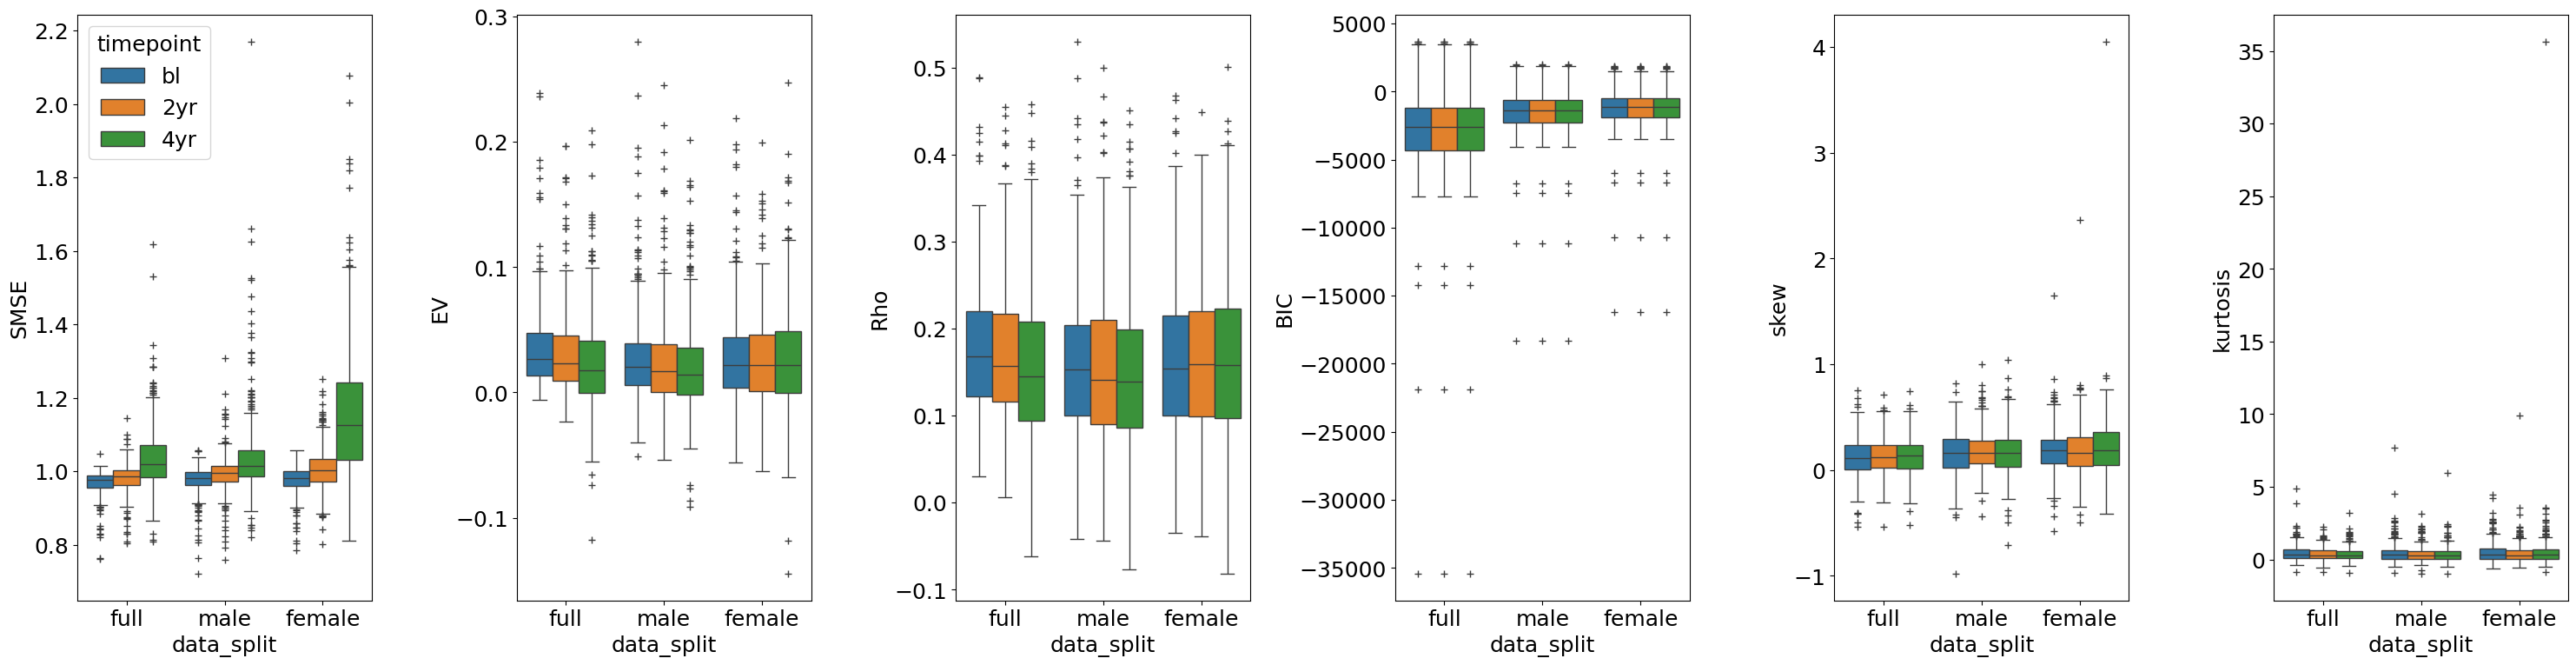

In [12]:
mpl.rcParams.update({'font.size': 18})

files = ["bl_performance_w4yr.csv", "2yr_performance_w4yr.csv", "4yr_performance_w4yr.csv"]

plotter = Plotter(model)
fig, axes = plotter.plot_performances(data_splits, file_names=files, figsize=(30, 8), use_bspline=False)

# ThicknessT1 + ageT1 + ageT2 + sex

In [13]:
os.chdir(proj_dir)
model_id = 'BNorm'
model = BNorm(ROI_lbls)
model.set_output_directories(proj_dir, atlas_to_use)

In [14]:
# Make the files for the full model
# 1. define the columns to use in the covariate matrix
coi1 = ['age_bl', 'age_2yr', 'sex_bl']
coi1 = [[*[x + '_bl'], *coi1] for x in ROI_lbls]

coi2 = ['age_bl', 'age_4yr', 'sex_bl']
coi2 = [[*[x + '_bl'], *coi2] for x in ROI_lbls]

# 2. define the targets
y_2yr = [roi + '_2yr' for roi in ROI_lbls]
y_4yr = [roi + '_4yr' for roi in ROI_lbls]

# create the files for the "full" condition
combs = [[coi1, y_2yr], 
         [coi2, y_4yr]]

sexes = ["full", "male", "female"]
# make the files for 5fold-CV for the full model data
#for i in range(5):
#    for split in ["train", "test"]:
#        print(i, split, "full", f"data/{atlas_to_use}/full_{split}_idcs_fold{i}.csv")
#        idcs = pd.read_csv(f"data/{atlas_to_use}/full_{split}_idcs_fold{i}.csv")
#        data = rdf_2yr.loc[idcs["index"].values]
#        make_files(data, coi1, y_2yr, os.path.join(model.data_dir, "full", f"fold{i}"), site_list=site_list, split=split)

make_files(rdf_2yr, coi1, y_2yr, os.path.join(model.data_dir, "full/2yr_only"), site_list=site_list, split="train")

tpts = ["2yr", "4yr"]

for i, comb in enumerate(combs):
    make_files(rdf_4yr, comb[0], comb[1], os.path.join(model.data_dir, "full/with_4yr"), site_list=site_list,  split="test")
    make_files(rdf_4yr[rdf_4yr.sex_bl == 1], comb[0], comb[1], os.path.join(model.data_dir, "full_male/with_4yr"), site_list=site_list,  split="test")
    make_files(rdf_4yr[rdf_4yr.sex_bl == 2], comb[0], comb[1], os.path.join(model.data_dir, "full_female/with_4yr"), site_list=site_list,  split="test")


362it [00:45,  7.98it/s]
362it [00:10, 33.20it/s]
362it [00:06, 52.91it/s]
362it [00:05, 60.45it/s]
362it [00:10, 33.53it/s]
362it [00:06, 53.19it/s]
362it [00:05, 60.84it/s]


In [15]:
# Make the files for the sexspecific models
# 1. define the columns to use in the covariate matrix
coi1 = ['age_bl', 'age_2yr']
coi1 = [[*[x + '_bl'], *coi1] for x in ROI_lbls]

coi2 = ['age_bl', 'age_4yr']
coi2 = [[*[x + '_bl'], *coi2] for x in ROI_lbls]

# 2. define the targets
y_2yr = [roi + '_2yr' for roi in ROI_lbls]
y_4yr = [roi + '_4yr' for roi in ROI_lbls]

# create the files for the "full" condition
combs = [[coi1, y_2yr], 
         [coi2, y_4yr]]

sexes = ["male", "female"]
# make the files for 5fold-CV for the full model data
for s, sex in enumerate(sexes): 
    for split in ["train", "test"]:

        data_to_use = rdf_2yr[rdf_2yr.sex_bl == (s+1)].reset_index(drop=True)
        # these are the files used to train on the complete (fe)male data
        print(sex, split, "full training file", os.path.join(model.data_dir, f"{sex}/2yr_only"))
        make_files(data_to_use, coi1, y_2yr, os.path.join(model.data_dir, f"{sex}/2yr_only"), site_list=site_list,  split="train")
        
        #for i in range(5):
        #    print(i, split, sexes[s], f"data/{atlas_to_use}/{sex}_{split}_idcs_fold{i}.csv")
        #    idcs = pd.read_csv(f"data/{atlas_to_use}/{sex}_{split}_idcs_fold{i}.csv")
        #    data = data_to_use.loc[idcs["index"].values]
        #    make_files(data, coi1, y_2yr, os.path.join(model.data_dir, sex, f"fold{i}"), site_list=site_list,  split=split)


# these are the test files containing data for participants with BL, 2-, and 4-year follow-up
tpts = ["2yr", "4yr"]
for i, comb in enumerate(combs):
    make_files(rdf_4yr[rdf_4yr.sex_bl == 1], comb[0], comb[1], os.path.join(model.data_dir, "male/with_4yr"), site_list=site_list, split="test")
    make_files(rdf_4yr[rdf_4yr.sex_bl == 2], comb[0], comb[1], os.path.join(model.data_dir, "female/with_4yr"), site_list=site_list, split="test")


male train full training file /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only


362it [00:27, 13.21it/s]


male test full training file /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only


362it [00:27, 13.17it/s]


female train full training file /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only


362it [00:24, 14.51it/s]


female test full training file /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only


362it [00:24, 14.63it/s]
362it [00:06, 52.22it/s]
362it [00:06, 59.61it/s]
362it [00:06, 53.19it/s]
362it [00:05, 61.96it/s]


## Train the model

In [16]:
# Train the model using all data from participants with only BL and 2-year follow-up data
for use_bspline in [False]:
    for s, split in enumerate(["full", "male", "female"]):
        train_dir = os.path.join(model.data_dir, f"{split}/2yr_only")
        test_dir = os.path.join(model.data_dir, f"{split}/with_4yr")
        model.train(train_dir, "2yr", test_dir, "2yr", data_split=split, suffix='_o2yr', use_bspline=use_bspline)
        os.system(f'say "{split} has completed"');


TRAINING ROI:  lh_avg
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_avg_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.58053e-63): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.5598e-30): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.18549e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -8870.174118
         Iterations: 6
         Function evaluations: 288
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_V1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6109.181636
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.08191e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.84346e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.17843e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5031.365356
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_MST/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V6
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_V6_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.67752e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.98489e-37): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.17254e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5583.415492
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_V6/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_V2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -7131.926158
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.35331e-32): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.19343e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.45426e-32): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.74589e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6552.771371
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_V4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_V8_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.12247e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.08318e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4496.436865
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_V8/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_4
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_4_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4893.220576
         Iterations: 9
         Function evaluations: 454
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.67747e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4983.280960
         Iterations: 10
         Function evaluations: 462
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_3b/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_FEF
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_FEF_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.90035e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3816.287043
         Iterations: 7
         Function evaluations: 354
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_FEF/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PEF
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PEF_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2999.631952
         Iterations: 8
         Function evaluations: 386
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.21873e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.98819e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5080.928672
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_RSC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_POS2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_POS2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.60134e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.96428e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.00282e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -6036.016908
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_POS2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V7
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_V7_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4322.363167
         Iterations: 8
         Function evaluations: 401
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.95696e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.41541e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5387.951244
         Iterations: 2
         Function evaluations: 89
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_FFC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V3B
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_V3B_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.30134e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.7466e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4968.510130
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_V3B/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_LO1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_LO1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4677.891987
         Iterations: 8
         Function evaluations: 396
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.25675e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3817.343303
         Iterations: 7
         Function evaluations: 345
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_LO2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PIT
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PIT_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3539.657221
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.99157e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3480.480203
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_A1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PSL
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PSL_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3330.634481
         Iterations: 9
         Function evaluations: 455
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.221e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3009.616310
         Iterations: 7
         Function evaluations: 361
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_STV/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_7Pm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_7Pm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3848.215431
         Iterations: 2
         Function evaluations: 89
Saving model meta-data...
Evaluating the model ...
Wr

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.19794e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.91184e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5311.573256
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_7m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_POS1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_POS1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.41734e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.41153e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5513.735883
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_POS1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_23d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_23d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3975.114053
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.11299e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.48511e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4196.115727
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_d23ab/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_31pv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_31pv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4947.319054
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.2414e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.26441e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4219.745706
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_5m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_5mv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_5mv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.67834e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.33171e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.90567e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5611.890077
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_5mv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_23c
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_23c_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6212.108187
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.54469e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.95065e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4521.972954
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_24dv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_7AL
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_7AL_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3287.064868
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Wr

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.76887e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2830.695997
         Iterations: 8
         Function evaluations: 410
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_6ma/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_7Am
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_7Am_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4291.583344
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Wr

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.84787e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3005.513526
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_7PL/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_7PC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_7PC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3444.847256
         Iterations: 7
         Function evaluations: 362
Saving model meta-data...
Evaluating the model ...
Wr

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.73916e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4316.985945
         Iterations: 5
         Function evaluations: 250
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_LIPv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_VIP
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_VIP_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2577.690830
         Iterations: 7
         Function evaluations: 332
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.52257e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3626.082276
         Iterations: 8
         Function evaluations: 398
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6125.788297
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing 

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.50796e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.3948e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.91886e-35): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.03686e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6906.250700
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_3a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_6d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_6d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1668.655702
         Iterations: 8
         Function evaluations: 395
Saving model meta-data...
Evaluating the model ...
Writi

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.64187e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2436.736251
         Iterations: 2
         Function evaluations: 88
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_33pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_a24pr
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_a24pr_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.47797e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.93887e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3717.712301
         Iterations: 2
         Function evaluations: 89
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_a24pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_p32pr
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_p32pr_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4359.249737
         Iterations: 8
         Function evaluations: 405
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.59489e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3535.974921
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_8BM/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_p32
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_p32_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3501.474648
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.12213e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.07237e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4739.842814
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_9m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_8BL
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_8BL_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1859.504962
         Iterations: 7
         Function evaluations: 356
Saving model meta-data...
Evaluating the model ...
Wri

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.7125e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.60544e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3957.640600
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_10d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_8C
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_8C_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.82731e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.37409e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5821.665123
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_8C/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_44
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_44_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5148.487250
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.19589e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.08851e-16): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.12281e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4799.380322
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_47l/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_a47r
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_a47r_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.09367e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4748.260261
         Iterations: 7
         Function evaluations: 344
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_a47r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_6r
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_6r_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.31108e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5861.403979
         Iterations: 8
         Function evaluations: 421
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_6r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IFJa
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_IFJa_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5240.499758
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.54562e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.21521e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4402.777370
         Iterations: 8
         Function evaluations: 412
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_IFJp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IFSp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_IFSp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5107.370618
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.20151e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.33222e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5737.629462
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_IFSa/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_p9-46v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_p9-46v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.08448e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.19441e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5357.531600
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_p9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_46
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_46_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5158.617931
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.4119e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5126.254431
         Iterations: 7
         Function evaluations: 355
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_a9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_9-46d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_9-46d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5782.268425
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.18324e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.10995e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4725.068643
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_9a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_10v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_10v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3548.496901
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writ

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.87275e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2561.087004
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_10pp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_11l
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_11l_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3303.827160
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Wr

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.38423e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.07832e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5978.029163
         Iterations: 9
         Function evaluations: 443
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_6a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_i6-8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_i6-8_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3644.661858
         Iterations: 10
         Function evaluations: 481
Saving model meta-data...
Evaluating the model ...

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.63337e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.88607e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5118.643022
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_OP4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_OP1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_OP1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.95379e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.03241e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4114.620582
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_OP1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_OP2-3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_OP2-3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3949.802237
         Iterations: 2
         Function evaluations: 95
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.74158e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.32852e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5546.124465
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_RI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PFcm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PFcm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5454.535947
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.12382e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: 131.914153
         Iterations: 8
         Function evaluations: 383
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_PoI2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TA2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_TA2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2396.035978
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Wr

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.39565e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2627.049231
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_MI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_Pir
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_Pir_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: 1143.087270
         Iterations: 9
         Function evaluations: 435
Saving model meta-data...
Evaluating the model ...
Writ

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.11773e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: -572.148515
         Iterations: 8
         Function evaluations: 415
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_AAIC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_FOP1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_FOP1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2897.137215
         Iterations: 7
         Function evaluations: 345
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.11405e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3570.831142
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_FOP2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PFt
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PFt_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.60504e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.24549e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.63896e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5395.716543
         Iterations: 2
         Function evaluations: 89
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_PFt/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_AIP
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_AIP_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6235.268960
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.03973e-87): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.96904e-39): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.37575e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py

Optimization terminated successfully.
         Current function value: -18372.836137
         Iterations: 9
         Function evaluations: 468
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_ProS_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3684.344682
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.87883e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2329.427755
         Iterations: 8
         Function evaluations: 411
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_PeEc/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_STGa
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_STGa_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1466.762764
         Iterations: 8
         Function evaluations: 405
Saving model meta-data...
Evaluating the model ..

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.6315e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.16078e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4181.252135
         Iterations: 8
         Function evaluations: 396
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_A5/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PHA1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PHA1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3181.421651
         Iterations: 6
         Function evaluations: 303
Saving model meta-data...
Evaluating the model ...


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.64357e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.47847e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4660.312376
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_STSda/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_STSdp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_STSdp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.14279e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.46884e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5853.412517
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_STSdp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_STSvp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_STSvp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5572.167063
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.13192e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4236.415727
         Iterations: 10
         Function evaluations: 498
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_TE1a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TE1p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_TE1p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5011.170742
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.41001e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.09857e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4353.538960
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_TE2a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TF
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_TF_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.73153e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.46607e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4450.330172
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_TF/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TE2p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_TE2p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4756.840139
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.21833e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4794.219707
         Iterations: 5
         Function evaluations: 240
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_PHT/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PH
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PH_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6161.211559
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.215e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.68912e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.57227e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5709.048365
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_TPOJ1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TPOJ2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_TPOJ2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.35892e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.45235e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5244.393136
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_TPOJ2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TPOJ3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_TPOJ3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4370.408040
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.99703e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.02754e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4351.514823
         Iterations: 9
         Function evaluations: 448
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_PGp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IP2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_IP2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5594.494280
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.73611e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.38754e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5872.700181
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_IP1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IP0
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_IP0_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.43964e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5972.835648
         Iterations: 8
         Function evaluations: 412
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_IP0/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PFop
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PFop_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4364.652987
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.70065e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.53499e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3897.853415
         Iterations: 8
         Function evaluations: 412
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_PF/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PFm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PFm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.03388e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4292.546250
         Iterations: 8
         Function evaluations: 414
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_PFm/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PGi
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PGi_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6402.276792
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.10333e-30): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.17725e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.78696e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


TRAINING ROI:  lh_L_PGs
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PGs_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4711.027611
         Iterations: 9
         Function evaluations: 458
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_PGs/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V6A
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_V6A_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparame

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.67905e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.83873e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5122.901857
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_VMV3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PHA2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PHA2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.04741e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3664.551567
         Iterations: 6
         Function evaluations: 307
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_PHA2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V4t
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_V4t_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.48551e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3844.828029
         Iterations: 7
         Function evaluations: 335
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_V4t/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_FST
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_FST_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5324.610188
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.64357e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.60236e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4647.438695
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_V3CD/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_LO3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_LO3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.29649e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.14139e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4483.654487
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_LO3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_VMV2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_VMV2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4156.282415
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.13023e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.46254e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3832.262994
         Iterations: 2
         Function evaluations: 89
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_31a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_VVC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_VVC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4660.843689
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.61552e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -181.045074
         Iterations: 15
         Function evaluations: 711
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_25/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_s32
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_s32_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1724.658960
         Iterations: 14
         Function evaluations: 651
Saving model meta-data...
Evaluating the model ...
W

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.66417e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.81529e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4536.853751
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_Ig/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_FOP5
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_FOP5_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4242.327381
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.60268e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.95916e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5080.646080
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_p47r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TGv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_TGv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1615.223325
         Iterations: 7
         Function evaluations: 362
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.38173e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.94827e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4626.692321
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_LBelt/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_A4
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_A4_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.39275e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.79833e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4600.011509
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_A4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_STSva
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_STSva_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5006.801755
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.03406e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3748.623293
         Iterations: 5
         Function evaluations: 253
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_TE1m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_PI_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1977.362168
         Iterations: 7
         Function evaluations: 353
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.5621e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3850.144626
         Iterations: 8
         Function evaluations: 401
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/lh_L_a32pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_p24
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/lh_L_p24_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2899.289270
         Iterations: 8
         Function evaluations: 389
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.5312e-74): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.26882e-34): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.50627e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -9387.304159
         Iterations: 4
         Function evaluations: 197
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_V1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6119.915485
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.71687e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.56974e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.64379e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5260.783786
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_MST/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V6
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_V6_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.51335e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5672.119144
         Iterations: 9
         Function evaluations: 451
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_V6/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_V2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -7138.952365
         Iterations: 2
         Function evaluations: 95
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.68017e-37): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.24324e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.67965e-33): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.40409e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6648.139605
         Iterations: 2
         Function evaluations: 95
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_V3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V4
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_V4_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.91024e-32): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.1018e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.37214e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -6614.557969
         Iterations: 2
         Function evaluations: 95
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_V4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_V8_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4944.407150
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.32894e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4114.951309
         Iterations: 8
         Function evaluations: 407
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_3b
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_3b_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3870.992735
         Iterations: 8
         Function evaluations: 350
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.02752e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.31446e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5151.961757
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_RSC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_POS2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_POS2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.30895e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.99307e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.89726e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -6100.131836
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_POS2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V7
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_V7_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4285.788587
         Iterations: 8
         Function evaluations: 392
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.64451e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.98499e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5458.836606
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_FFC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V3B
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_V3B_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.30919e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.56532e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5400.778720
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_V3B/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_LO1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_LO1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4408.708582
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.4702e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.51018e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4711.457337
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_MT/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_A1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_A1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3489.416179
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writin

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.94168e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.36809e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4043.892578
         Iterations: 8
         Function evaluations: 402
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_STV/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_7Pm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_7Pm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3454.738915
         Iterations: 2
         Function evaluations: 107
Saving model meta-data...
Evaluating the model ...
W

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.13812e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.58691e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5287.332924
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_POS1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_23d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_23d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.6702e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.9217e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4180.452520
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_23d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_v23ab
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_v23ab_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4166.116532
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.68758e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.3206e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4840.024956
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_31pv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_5m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_5m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4144.612045
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.10856e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.01098e-30): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.23945e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -6318.352106
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_23c/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_5L
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_5L_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2885.587290
         Iterations: 8
         Function evaluations: 400
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.19573e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.33117e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4832.072628
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_24dv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_7AL
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_7AL_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2903.425321
         Iterations: 7
         Function evaluations: 347
Saving model meta-data...
Evaluating the model ...
W

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.17044e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3079.316595
         Iterations: 7
         Function evaluations: 363
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_6ma/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_7Am
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_7Am_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3641.091026
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Wr

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.09852e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2988.023264
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_7PL/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_7PC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_7PC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3260.814984
         Iterations: 7
         Function evaluations: 365
Saving model meta-data...
Evaluating the model ...
Wr

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.28599e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2456.813711
         Iterations: 5
         Function evaluations: 257
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_VIP/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_MIP
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_MIP_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5150.927718
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Wr

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.32742e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3235.037553
         Iterations: 7
         Function evaluations: 356
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5731.908743
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing 

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.95768e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.44219e-31): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.21949e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6434.151459
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_3a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_6d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_6d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1246.100409
         Iterations: 8
         Function evaluations: 396
Saving model meta-data...
Evaluating the model ...
Writi

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.70257e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3123.900934
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_33pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_a24pr
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_a24pr_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.33889e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.00052e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3636.689228
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_a24pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p32pr
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_p32pr_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4582.604667
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.11972e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.26088e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4269.891255
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_d32/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_8BM
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_8BM_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3922.645660
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: -3200.794928
         Iterations: 8
         Function evaluations: 410
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_8Av/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_8Ad
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_8Ad_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5010.685455
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.42145e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.50644e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4931.275722
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_9m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_8BL
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_8BL_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3026.182325
         Iterations: 6
         Function evaluations: 303
Saving model meta-data...
Evaluating the model ...
Wri

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.04646e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3579.447481
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_10d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_8C
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_8C_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.55484e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.95514e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5639.033061
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_8C/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_44
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_44_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5055.015159
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.42907e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.10531e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4766.566509
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_47l/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_a47r
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_a47r_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5118.764932
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.86353e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.53539e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5929.059779
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_6r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IFJa
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_IFJa_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.61072e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.08722e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4582.196691
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_IFJa/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IFJp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_IFJp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3896.016614
         Iterations: 8
         Function evaluations: 386
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.44406e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.07655e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5109.883546
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_IFSa/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p9-46v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_p9-46v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.43385e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.37123e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4936.000748
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_p9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_46
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_46_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5335.703971
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.82141e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.27162e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5745.902135
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_9-46d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_9a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_9a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3866.864134
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.88133e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3216.655634
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_10v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_a10p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_a10p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.07757e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3964.272356
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_a10p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_10pp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_10pp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3033.159883
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.69605e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.25826e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4618.749710
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_LIPd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_6a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_6a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5724.885109
         Iterations: 11
         Function evaluations: 549
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.11616e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.10989e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5165.546124
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_OP4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_OP1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_OP1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2945.012612
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Wri

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.72568e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3493.421875
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_52/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_RI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_RI_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.40307e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.0654e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5448.559675
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_RI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PFcm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_PFcm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4979.503369
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.85254e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2538.340849
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_MI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_Pir
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_Pir_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: 911.312820
         Iterations: 7
         Function evaluations: 352
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.70913e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_AVI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_AAIC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_AAIC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -779.143295
         Iterations: 7
         Function evaluations: 364
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_AAIC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs 

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.65027e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.52104e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3893.756227
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_FOP2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PFt
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_PFt_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3908.208906
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.40546e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.11616e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.13826e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6074.749463
         Iterations: 9
         Function evaluations: 463
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_AIP/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_EC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_EC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -605.961173
         Iterations: 6
         Function evaluations: 292
Saving model meta-data...
Evaluating the model ...
Writ

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.03853e-87): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.96878e-39): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.37543e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py

Optimization terminated successfully.
         Current function value: -13360.176503
         Iterations: 7
         Function evaluations: 361
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_ProS_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3757.351131
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.17755e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1953.716425
         Iterations: 7
         Function evaluations: 356
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_PeEc/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STGa
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_STGa_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1368.437615
         Iterations: 7
         Function evaluations: 351
Saving model meta-data...
Evaluating the model ..

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.93028e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.87474e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4629.703289
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_A5/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PHA1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_PHA1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3074.090727
         Iterations: 2
         Function evaluations: 89
Saving model meta-data...
Evaluating the model ...
Wr

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.41587e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.41683e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4999.388312
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_STSda/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STSdp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_STSdp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.46598e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.74357e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5835.677236
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_STSdp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STSvp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_STSvp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4874.642554
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.57186e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4082.580165
         Iterations: 9
         Function evaluations: 452
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_TE1a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE1p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_TE1p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.05121e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4598.009778
         Iterations: 8
         Function evaluations: 390
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_TE1p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE2a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_TE2a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4621.652316
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.53597e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.20337e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4588.790107
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_TF/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE2p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_TE2p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.81768e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.75223e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4874.814607
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_TE2p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PHT
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_PHT_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4846.023225
         Iterations: 5
         Function evaluations: 255
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.75703e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.97073e-31): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.09932e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6435.145082
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_TPOJ1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TPOJ2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_TPOJ2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.90316e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.71807e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5630.863935
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_TPOJ2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TPOJ3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_TPOJ3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5088.162932
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.21563e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.2748e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4620.897577
         Iterations: 8
         Function evaluations: 411
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_PGp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IP2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_IP2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5217.995397
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.88374e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.985e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5194.330409
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_IP1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IP0
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_IP0_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.60975e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.29766e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -6025.687461
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_IP0/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PFop
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_PFop_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3243.529010
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.96809e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4573.187470
         Iterations: 8
         Function evaluations: 411
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_PFm/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PGi
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_PGi_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -6109.770989
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.91478e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.71564e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.85858e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3741.385341
         Iterations: 9
         Function evaluations: 454
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_PGs/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V6A
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_V6A_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2621.422518
         Iterations: 7
         Function evaluations: 356
Saving model meta-data...
Evaluating the model ...
W

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.8792e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4126.397771
         Iterations: 6
         Function evaluations: 294
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_VMV1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_VMV3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_VMV3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5249.630277
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.1538e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.27085e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3946.011271
         Iterations: 7
         Function evaluations: 350
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_PHA2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V4t
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_V4t_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3566.822523
         Iterations: 7
         Function evaluations: 347
Saving model meta-data...
Evaluating the model ...


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.13036e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.65286e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -5038.340433
         Iterations: 8
         Function evaluations: 398
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_V3CD/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_LO3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_LO3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4531.219385
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
W

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.80449e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.03355e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4433.613343
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_VMV2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_31pd
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_31pd_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.27183e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.78894e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4482.424346
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_31pd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_31a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_31a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3876.604488
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.6014e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 272.402515
         Iterations: 8
         Function evaluations: 396
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_25/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_s32
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_s32_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1519.216588
         Iterations: 11
         Function evaluations: 507
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.66334e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.35282e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3882.713803
         Iterations: 2
         Function evaluations: 95
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_Ig/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_FOP5
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_FOP5_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4370.289556
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.28275e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.06999e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4306.009290
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_p47r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TGv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_TGv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1768.075861
         Iterations: 7
         Function evaluations: 357
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.06415e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.84112e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_LBelt
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_LBelt_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -4121.213846
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_LBelt/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_A4
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/res

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.46503e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.34683e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5068.204628
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_STSva/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE1m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_TE1m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.7092e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3916.097139
         Iterations: 8
         Function evaluations: 381
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_TE1m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/full/2yr_only/resp_files_train/rh_R_PI_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2785.627657
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.3886e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3136.694515
         Iterations: 8
         Function evaluations: 380
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/full/rh_R_p24/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_avg
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_avg_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.08427e-65): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.19714e-31): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.32004e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4753.694325
         Iterations: 6
         Function evaluations: 296
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_V1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3269.442025
         Iterations: 3
         Function evaluations: 142
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.89597e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.72249e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.01077e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2640.463178
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_MST/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V6
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_V6_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2974.472571
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.97458e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.69807e-37): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.57955e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3758.116190
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_V2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_V3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.30504e-32): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.56853e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3478.147190
         Iterations: 8
         Function evaluations: 394
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_V3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V4
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_V4_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.57474e-30): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.31929e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3364.362843
         Iterations: 9
         Function evaluations: 435
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_V4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_V8_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2352.061616
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.44908e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.64777e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2526.607868
         Iterations: 11
         Function evaluations: 534
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_3b
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_3b_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.1044e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2601.604858
         Iterations: 10
         Function evaluations: 458
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_3b/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_FEF
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_FEF_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.46249e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2077.311219
         Iterations: 9
         Function evaluations: 459
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_FEF/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PEF
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_PEF_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1398.327552
         Iterations: 7
         Function evaluations: 354
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.31675e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.00664e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2658.425282
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_RSC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_POS2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_POS2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3183.910838
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.68591e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.01993e-16): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.93682e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2164.270154
         Iterations: 8
         Function evaluations: 407
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_V7/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IPS1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_IPS1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2976.750074
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.68525e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.9883e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2747.454863
         Iterations: 3
         Function evaluations: 141
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_FFC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V3B
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_V3B_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.04343e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2534.180339
         Iterations: 7
         Function evaluations: 350
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_V3B/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_LO1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_LO1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.58277e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2397.264938
         Iterations: 5
         Function evaluations: 256
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_LO1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_LO2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_LO2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1933.259060
         Iterations: 8
         Function evaluations: 401
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.94112e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2432.785550
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_MT/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_A1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_A1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1812.435690
         Iterations: 6
         Function evaluations: 298
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.1453e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1501.854803
         Iterations: 7
         Function evaluations: 363
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_STV/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_7Pm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_7Pm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1988.409233
         Iterations: 3
         Function evaluations: 141
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.93259e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.59375e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2886.989147
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_7m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_POS1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_POS1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2915.637084
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.73359e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.38896e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2096.625511
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_23d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_v23ab
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_v23ab_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.48628e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2244.982193
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_v23ab/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_d23ab
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_d23ab_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.67967e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2188.012152
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_d23ab/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_31pv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_31pv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.33583e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2610.910062
         Iterations: 8
         Function evaluations: 383
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_31pv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_5m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_5m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.6752e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2240.961382
         Iterations: 5
         Function evaluations: 250
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_5m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_5mv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_5mv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2999.611690
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.86823e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.21252e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.57114e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3277.264186
         Iterations: 6
         Function evaluations: 301
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_23c/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_5L
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_5L_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1670.148131
         Iterations: 8
         Function evaluations: 398
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.62619e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2735.288684
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_24dd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_24dv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_24dv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.06023e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2408.032384
         Iterations: 8
         Function evaluations: 380
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_24dv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_7AL
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_7AL_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1675.779938
         Iterations: 6
         Function evaluations: 296
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.00535e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1473.904878
         Iterations: 7
         Function evaluations: 367
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_6ma/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_7Am
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_7Am_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.68676e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2207.882454
         Iterations: 6
         Function evaluations: 295
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_7Am/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_7PL
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_7PL_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1532.245368
         Iterations: 3
         Function evaluations: 141
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.17905e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1335.707262
         Iterations: 8
         Function evaluations: 394
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_VIP/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_MIP
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_MIP_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2766.002479
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.53664e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1937.833129
         Iterations: 8
         Function evaluations: 385
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.83125e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3173.486092
         Iterations: 8
         Function evaluations: 393
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_3a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_3a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3579.184061
         Iterations: 2
         Function evaluations: 95
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.4825e-34): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.9214e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -779.184870
         Iterations: 8
         Function evaluations: 403
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_6d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_6mp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_6mp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1421.623248
         Iterations: 8
         Function evaluations: 401
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.98604e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1338.375483
         Iterations: 3
         Function evaluations: 138
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_33pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_a24pr
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_a24pr_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1942.902547
         Iterations: 6
         Function evaluations: 294
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.26396e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2320.201198
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_p32pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_a24
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_a24_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1588.314690
         Iterations: 7
         Function evaluations: 343
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.79353e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2165.966164
         Iterations: 7
         Function evaluations: 353
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_d32/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_8BM
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_8BM_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1783.734391
         Iterations: 6
         Function evaluations: 289
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.64079e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2814.192523
         Iterations: 8
         Function evaluations: 400
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_8Ad/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_9m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_9m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.11318e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2485.930968
         Iterations: 8
         Function evaluations: 381
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_9m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_8BL
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_8BL_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -955.436325
         Iterations: 7
         Function evaluations: 354
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.58856e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2148.764005
         Iterations: 8
         Function evaluations: 400
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_9p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_10d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_10d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2175.353803
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.05326e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.25949e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3074.019592
         Iterations: 6
         Function evaluations: 292
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_8C/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_44
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_44_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2640.773465
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.01029e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.6087e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3150.837909
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_45/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_47l
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_47l_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2522.121540
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.08957e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.27231e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2516.841526
         Iterations: 8
         Function evaluations: 390
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_a47r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_6r
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_6r_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.8749e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3001.804272
         Iterations: 10
         Function evaluations: 494
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_6r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IFJa
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_IFJa_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2758.935711
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.52392e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.40905e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2264.061482
         Iterations: 9
         Function evaluations: 447
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_IFJp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IFSp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_IFSp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2660.963529
         Iterations: 3
         Function evaluations: 142
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.72257e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.95842e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3082.691463
         Iterations: 3
         Function evaluations: 141
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_IFSa/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_p9-46v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_p9-46v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.8029e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2769.168974
         Iterations: 5
         Function evaluations: 244
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_p9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_46
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_46_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.64281e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2721.578555
         Iterations: 8
         Function evaluations: 396
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_46/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_a9-46v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_a9-46v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.95084e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2677.864948
         Iterations: 8
         Function evaluations: 399
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_a9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_9-46d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_9-46d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.14928e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3084.045832
         Iterations: 8
         Function evaluations: 407
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_9-46d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_9a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_9a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.03954e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2535.256273
         Iterations: 6
         Function evaluations: 305
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_9a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_10v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_10v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1844.871140
         Iterations: 6
         Function evaluations: 302
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.19961e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2124.695487
         Iterations: 8
         Function evaluations: 406
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_a10p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_10pp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_10pp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1428.242278
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.24255e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2745.033513
         Iterations: 7
         Function evaluations: 344
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_LIPd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_6a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_6a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.05308e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3106.946901
         Iterations: 9
         Function evaluations: 445
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_6a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_i6-8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_i6-8_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1913.197329
         Iterations: 8
         Function evaluations: 392
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.68913e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.91958e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2716.677757
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_OP4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_OP1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_OP1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2184.338595
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.65531e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.8452e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2072.969984
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_OP2-3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_52
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_52_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1929.670660
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.89853e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.75941e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2958.312468
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_RI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PFcm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_PFcm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2938.205485
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.48347e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: -2426.418217
         Iterations: 6
         Function evaluations: 314
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_FOP4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_MI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_MI_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1375.203989
         Iterations: 8
         Function evaluations: 397
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.39648e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2002.670718
         Iterations: 8
         Function evaluations: 393
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_AVI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_AAIC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_AAIC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -236.514189
         Iterations: 7
         Function evaluations: 359
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.07181e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2563.612229
         Iterations: 7
         Function evaluations: 357
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_FOP3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_FOP2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_FOP2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1793.723133
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.65215e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2809.496919
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_PFt/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_AIP
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_AIP_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.36774e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.82943e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3260.395784
         Iterations: 9
         Function evaluations: 430
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_AIP/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_EC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_EC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -442.942941
         Iterations: 5
         Function evaluations: 254
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.69927e-86): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.70138e-39): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.46589e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py

Optimization terminated successfully.
         Current function value: -9624.526291
         Iterations: 10
         Function evaluations: 525
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_ProS_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1908.747858
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.70766e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.34764e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2186.579257
         Iterations: 8
         Function evaluations: 397
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_A5/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PHA1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_PHA1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1590.892418
         Iterations: 7
         Function evaluations: 341
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.78851e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2730.750623
         Iterations: 8
         Function evaluations: 380
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_PHA3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_STSda
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_STSda_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.05358e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2409.272949
         Iterations: 8
         Function evaluations: 392
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_STSda/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_STSdp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_STSdp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3055.526700
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.19536e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.20372e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2905.847636
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_STSvp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TGd
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_TGd_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1368.463414
         Iterations: 9
         Function evaluations: 446
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.73898e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2070.426499
         Iterations: 12
         Function evaluations: 603
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_TE1a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TE1p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_TE1p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.8967e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2515.827017
         Iterations: 8
         Function evaluations: 399
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_TE1p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TE2a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_TE2a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.83676e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2237.800101
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_TE2a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TF
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_TF_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2377.593556
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.54211e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.18147e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2410.679454
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_TE2p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PHT
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_PHT_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.17914e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2410.736132
         Iterations: 8
         Function evaluations: 400
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_PHT/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PH
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_PH_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3178.711531
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.1228e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.07881e-16): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.79291e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3002.089213
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_TPOJ1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TPOJ2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_TPOJ2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2709.526387
         Iterations: 3
         Function evaluations: 142
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.32372e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.69696e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2313.310736
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_TPOJ3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_DVT
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_DVT_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3142.836838
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.35916e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.54729e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2217.422667
         Iterations: 10
         Function evaluations: 504
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_PGp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IP2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_IP2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2943.667973
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.32237e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.95685e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3048.448360
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_IP1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IP0
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_IP0_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.03026e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3059.176906
         Iterations: 8
         Function evaluations: 416
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_IP0/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PFop
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_PFop_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2419.664033
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.46905e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.08827e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2032.921995
         Iterations: 7
         Function evaluations: 368
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_PF/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PFm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_PFm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.01916e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: -2224.336929
         Iterations: 8
         Function evaluations: 420
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_PFm/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PGi
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_PGi_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.90692e-30): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.10835e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3371.630234
         Iterations: 6
         Function evaluations: 303
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_PGi/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PGs
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_PGs_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.82971e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2394.742639
         Iterations: 10
         Function evaluations: 492
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_PGs/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V6A
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_V6A_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1053.562134
         Iterations: 8
         Function evaluations: 401
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.56564e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.63432e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2694.604398
         Iterations: 7
         Function evaluations: 342
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_VMV3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PHA2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_PHA2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1879.645517
         Iterations: 7
         Function evaluations: 344
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.57545e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1984.518543
         Iterations: 9
         Function evaluations: 433
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_V4t/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_FST
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_FST_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2773.152701
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.5048e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.46765e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2363.768675
         Iterations: 6
         Function evaluations: 298
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_V3CD/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_LO3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_LO3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.20362e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2301.000778
         Iterations: 5
         Function evaluations: 253
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_LO3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_VMV2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_VMV2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.33342e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2196.035354
         Iterations: 7
         Function evaluations: 347
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_VMV2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_31pd
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_31pd_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.26191e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2886.570375
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_31pd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_31a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_31a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.72394e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2026.308664
         Iterations: 6
         Function evaluations: 296
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_31a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_VVC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_VVC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.46261e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2384.497186
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_VVC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_25
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_25_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -89.987336
         Iterations: 15
         Function evaluations: 714
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.20659e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.98323e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2243.965635
         Iterations: 7
         Function evaluations: 358
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_FOP5/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_p10p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_p10p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2419.010401
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.10246e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.73551e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2730.411325
         Iterations: 7
         Function evaluations: 347
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_p47r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TGv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_TGv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -838.363024
         Iterations: 7
         Function evaluations: 358
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.63169e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2297.866641
         Iterations: 5
         Function evaluations: 254
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_MBelt/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_LBelt
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_LBelt_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2488.762740
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.90428e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.67324e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2480.393382
         Iterations: 7
         Function evaluations: 342
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_A4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_STSva
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_STSva_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.45635e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2543.784247
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_STSva/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TE1m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_TE1m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1884.285289
         Iterations: 8
         Function evaluations: 396
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.59626e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1985.687713
         Iterations: 8
         Function evaluations: 392
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/lh_L_a32pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_p24
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/lh_L_p24_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1535.735507
         Iterations: 7
         Function evaluations: 333
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.91363e-77): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.0599e-35): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.09257e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -5027.940030
         Iterations: 5
         Function evaluations: 249
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_V1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3215.401846
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.73314e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.095e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.66934e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2724.747100
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_MST/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V6
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_V6_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.4086e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3009.513374
         Iterations: 9
         Function evaluations: 435
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_V6/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_V2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3752.772599
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.79183e-37): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.20924e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.50665e-32): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.48675e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3519.532610
         Iterations: 10
         Function evaluations: 495
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_V3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V4
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_V4_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.12866e-31): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.26029e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3435.190109
         Iterations: 9
         Function evaluations: 440
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_V4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_V8_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2543.994518
         Iterations: 3
         Function evaluations: 142
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.46806e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.79198e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2176.530611
         Iterations: 9
         Function evaluations: 456
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_3b
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_3b_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2056.203086
         Iterations: 9
         Function evaluations: 414
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.48005e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2462.738969
         Iterations: 6
         Function evaluations: 294
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_V3A/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_RSC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_RSC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2722.103031
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.74502e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.1595e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.06468e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3282.555044
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_POS2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V7
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_V7_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.44812e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2160.682170
         Iterations: 9
         Function evaluations: 438
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_V7/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IPS1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_IPS1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2979.324897
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.34098e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.08733e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2842.929456
         Iterations: 3
         Function evaluations: 140
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_FFC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V3B
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_V3B_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.76321e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2830.897302
         Iterations: 5
         Function evaluations: 253
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_V3B/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_LO1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_LO1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.48136e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2301.375829
         Iterations: 6
         Function evaluations: 295
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_LO1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_LO2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_LO2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1595.590641
         Iterations: 8
         Function evaluations: 400
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.49599e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2437.233766
         Iterations: 7
         Function evaluations: 344
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_MT/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_A1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_A1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1848.270071
         Iterations: 7
         Function evaluations: 345
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.28665e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2589.139444
         Iterations: 7
         Function evaluations: 347
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_PCV/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STV
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_STV_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.56294e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2154.692540
         Iterations: 8
         Function evaluations: 402
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_STV/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_7Pm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_7Pm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1905.242989
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.02091e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: -2859.564513
         Iterations: 6
         Function evaluations: 298
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_7m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_POS1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_POS1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2840.199944
         Iterations: 2
         Function evaluations: 89
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.13038e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.67209e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2200.578006
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_23d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_v23ab
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_v23ab_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.31139e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2274.542125
         Iterations: 6
         Function evaluations: 299
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_v23ab/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_d23ab
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_d23ab_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1738.284721
         Iterations: 7
         Function evaluations: 344
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.08116e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2552.651073
         Iterations: 8
         Function evaluations: 380
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_31pv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_5m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_5m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2153.211666
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.73227e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.21263e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3051.837139
         Iterations: 5
         Function evaluations: 248
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_5mv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_23c
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_23c_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3328.030587
         Iterations: 2
         Function evaluations: 95
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.51944e-30): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.67109e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1472.998077
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_5L/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_24dd
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_24dd_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2801.323560
         Iterations: 3
         Function evaluations: 141
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.87141e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.49562e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2566.590239
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_24dv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_7AL
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_7AL_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1451.323238
         Iterations: 8
         Function evaluations: 399
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.20849e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: -1552.815762
         Iterations: 7
         Function evaluations: 368
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_6ma/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_7Am
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_7Am_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1852.983834
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.4498e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1291.230682
         Iterations: 7
         Function evaluations: 346
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_VIP/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_MIP
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_MIP_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2653.478089
         Iterations: 3
         Function evaluations: 141
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.81195e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1865.345382
         Iterations: 8
         Function evaluations: 402
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.23863e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3109.504372
         Iterations: 5
         Function evaluations: 247
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_3a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_3a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3330.564035
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.70229e-30): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.68753e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -588.311700
         Iterations: 8
         Function evaluations: 411
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_6d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_6mp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_6mp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1321.171846
         Iterations: 8
         Function evaluations: 404
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.59155e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1715.738432
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_33pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_a24pr
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_a24pr_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.07977e-16): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1949.982662
         Iterations: 8
         Function evaluations: 380
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_a24pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p32pr
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_p32pr_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.10686e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2448.965925
         Iterations: 8
         Function evaluations: 381
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_p32pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_a24
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_a24_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1519.261085
         Iterations: 6
         Function evaluations: 295
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.02854e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2271.775512
         Iterations: 7
         Function evaluations: 336
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_d32/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_8BM
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_8BM_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.96929e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2074.098175
         Iterations: 7
         Function evaluations: 347
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_8BM/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p32
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_p32_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1864.003967
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.19514e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2584.225987
         Iterations: 8
         Function evaluations: 401
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_8Ad/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_9m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_9m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2613.938639
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.60394e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1634.221821
         Iterations: 7
         Function evaluations: 333
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_8BL/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_9p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_9p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.31248e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2109.321448
         Iterations: 7
         Function evaluations: 352
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_9p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_10d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_10d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.07051e-16): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1949.191553
         Iterations: 7
         Function evaluations: 332
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_10d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_8C
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_8C_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.23708e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2938.894645
         Iterations: 8
         Function evaluations: 380
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_8C/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_44
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_44_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2616.812091
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.65258e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.10219e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2768.324639
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_45/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_47l
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_47l_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2542.476612
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.32262e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.12329e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2747.651363
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_a47r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_6r
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_6r_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.30827e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3056.005534
         Iterations: 5
         Function evaluations: 255
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_6r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IFJa
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_IFJa_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2333.867746
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.28762e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.16465e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2015.021387
         Iterations: 5
         Function evaluations: 252
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_IFJp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IFSp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_IFSp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2640.598383
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.02389e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.67058e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2686.609067
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_IFSa/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p9-46v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_p9-46v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.30065e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2602.360761
         Iterations: 8
         Function evaluations: 410
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_p9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_46
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_46_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.66949e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2874.234051
         Iterations: 9
         Function evaluations: 437
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_46/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_a9-46v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_a9-46v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.54088e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2335.634315
         Iterations: 7
         Function evaluations: 346
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_a9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_9-46d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_9-46d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.83669e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3036.923436
         Iterations: 9
         Function evaluations: 431
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_9-46d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_9a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_9a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.31068e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2049.734718
         Iterations: 8
         Function evaluations: 401
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_9a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_10v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_10v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1720.348171
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.03462e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2120.695249
         Iterations: 8
         Function evaluations: 392
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_a10p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_10pp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_10pp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1632.202322
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.02747e-16): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1241.866934
         Iterations: 8
         Function evaluations: 388
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_47s/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_LIPd
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_LIPd_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2479.069973
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.46364e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.97666e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2994.680511
         Iterations: 15
         Function evaluations: 734
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_6a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_i6-8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_i6-8_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1293.776849
         Iterations: 7
         Function evaluations: 368
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.66655e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.18874e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2739.330408
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_OP4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_OP1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_OP1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1586.531157
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.11446e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2122.354514
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_OP2-3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_52
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_52_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1814.370864
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.89994e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.93954e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2875.136556
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_RI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PFcm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_PFcm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2674.409387
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.83651e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2322.596393
         Iterations: 5
         Function evaluations: 254
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_FOP4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_MI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_MI_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1327.648344
         Iterations: 8
         Function evaluations: 404
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.64182e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2159.961026
         Iterations: 7
         Function evaluations: 355
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_AVI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_AAIC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_AAIC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -394.866218
         Iterations: 9
         Function evaluations: 437
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.3988e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2409.188609
         Iterations: 8
         Function evaluations: 405
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_FOP3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_FOP2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_FOP2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.95364e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2042.637120
         Iterations: 6
         Function evaluations: 301
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_FOP2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PFt
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_PFt_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.89678e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2074.338386
         Iterations: 6
         Function evaluations: 295
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_PFt/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_AIP
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_AIP_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.24364e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.6565e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3267.074007
         Iterations: 4
         Function evaluations: 205
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_AIP/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_EC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_EC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -204.038819
         Iterations: 7
         Function evaluations: 336
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.69904e-86): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.70086e-39): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.46527e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py

Optimization terminated successfully.
         Current function value: -6898.247451
         Iterations: 7
         Function evaluations: 369
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_ProS_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1949.747970
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.83803e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -978.689509
         Iterations: 7
         Function evaluations: 359
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_PeEc/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STGa
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_STGa_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -692.917812
         Iterations: 10
         Function evaluations: 502
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.13409e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.15013e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2466.374464
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_A5/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PHA1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_PHA1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1637.981541
         Iterations: 3
         Function evaluations: 140
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.9538e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2493.982495
         Iterations: 8
         Function evaluations: 400
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_PHA3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STSda
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_STSda_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2648.299742
         Iterations: 3
         Function evaluations: 141
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.74451e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.46665e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3090.833196
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_STSdp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STSvp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_STSvp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2517.165267
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.17189e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1405.581087
         Iterations: 9
         Function evaluations: 449
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_TGd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE1a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_TE1a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.62055e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2056.742737
         Iterations: 10
         Function evaluations: 486
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_TE1a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE1p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_TE1p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.06121e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2345.627007
         Iterations: 10
         Function evaluations: 491
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_TE1p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE2a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_TE2a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.86725e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2351.177198
         Iterations: 8
         Function evaluations: 379
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_TE2a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TF
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_TF_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2416.315930
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.91649e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.67694e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2576.768622
         Iterations: 6
         Function evaluations: 295
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_TE2p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PHT
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_PHT_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.33324e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2431.635356
         Iterations: 6
         Function evaluations: 294
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_PHT/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PH
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_PH_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2934.683374
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.07165e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.60565e-30): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.32136e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3347.051899
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_TPOJ1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TPOJ2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_TPOJ2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2951.932935
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.7857e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.1928e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2636.662346
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_TPOJ3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_DVT
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_DVT_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3141.856393
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.4083e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.31804e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2298.578498
         Iterations: 9
         Function evaluations: 464
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_PGp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IP2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_IP2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.87734e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2753.489828
         Iterations: 7
         Function evaluations: 346
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_IP2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IP1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_IP1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.06865e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2680.338741
         Iterations: 7
         Function evaluations: 352
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_IP1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IP0
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_IP0_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.79077e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.90553e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3203.121449
         Iterations: 7
         Function evaluations: 349
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_IP0/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PFop
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_PFop_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1888.554640
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.8488e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2429.992866
         Iterations: 8
         Function evaluations: 421
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_PFm/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PGi
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_PGi_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.22785e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.57835e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3199.402201
         Iterations: 8
         Function evaluations: 378
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_PGi/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PGs
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_PGs_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1987.755349
         Iterations: 9
         Function evaluations: 463
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.95187e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.05074e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2752.912088
         Iterations: 7
         Function evaluations: 345
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_VMV3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PHA2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_PHA2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.03315e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2008.438000
         Iterations: 7
         Function evaluations: 356
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_PHA2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V4t
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_V4t_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1783.190256
         Iterations: 9
         Function evaluations: 461
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.88883e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.62993e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2667.134845
         Iterations: 8
         Function evaluations: 393
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_V3CD/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_LO3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_LO3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2357.714787
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.24409e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.97289e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2320.707001
         Iterations: 8
         Function evaluations: 391
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_VMV2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_31pd
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_31pd_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2393.514745
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.10683e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.07303e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2111.615672
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_31a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_VVC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_VVC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2524.751670
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_ou

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.03497e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 136.490209
         Iterations: 7
         Function evaluations: 350
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_25/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_s32
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_s32_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -882.496125
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.25157e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.45114e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2330.774404
         Iterations: 6
         Function evaluations: 311
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_FOP5/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p10p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_p10p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.99857e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2456.520840
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_p10p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p47r
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_p47r_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2242.905889
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.44702e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -864.593607
         Iterations: 7
         Function evaluations: 360
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_TGv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_MBelt
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_MBelt_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2256.874965
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.1805e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.81382e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2231.236717
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_LBelt/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_A4
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_A4_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.08938e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2344.278129
         Iterations: 7
         Function evaluations: 347
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_A4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STSva
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_STSva_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.16358e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2582.918451
         Iterations: 9
         Function evaluations: 432
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_STSva/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE1m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_TE1m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1909.985867
         Iterations: 9
         Function evaluations: 440
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.63923e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2045.326823
         Iterations: 7
         Function evaluations: 351
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/male/rh_R_a32pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p24
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/male/2yr_only/resp_files_train/rh_R_p24_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1597.592856
         Iterations: 8
         Function evaluations: 395
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.75166e-59): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.38451e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.38738e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4037.357021
         Iterations: 5
         Function evaluations: 245
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_V1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2764.756795
         Iterations: 3
         Function evaluations: 142
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.02528e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.12045e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2313.551183
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_MST/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V6
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_V6_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.05321e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2544.409332
         Iterations: 6
         Function evaluations: 296
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_V6/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_V2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3287.648909
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.53567e-37): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.4958e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.25591e-32): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.39969e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3061.798623
         Iterations: 6
         Function evaluations: 303
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_V3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V4
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_V4_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.43637e-33): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.60415e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3140.360802
         Iterations: 6
         Function evaluations: 295
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_V4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_V8_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2068.662132
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.35394e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.77203e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2280.898383
         Iterations: 11
         Function evaluations: 558
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_3b
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_3b_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.23953e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2320.225114
         Iterations: 10
         Function evaluations: 452
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_3b/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_FEF
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_FEF_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1678.799369
         Iterations: 7
         Function evaluations: 343
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.34085e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2154.362575
         Iterations: 6
         Function evaluations: 298
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_V3A/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_RSC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_RSC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2345.312606
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.32112e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.63407e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2783.785993
         Iterations: 6
         Function evaluations: 302
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_POS2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V7
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_V7_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.27732e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2110.607501
         Iterations: 9
         Function evaluations: 428
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_V7/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IPS1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_IPS1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2658.992505
         Iterations: 3
         Function evaluations: 144
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.43732e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.34478e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2574.999264
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_FFC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V3B
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_V3B_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.47386e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2383.936706
         Iterations: 8
         Function evaluations: 392
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_V3B/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_LO1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_LO1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.45569e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2213.072973
         Iterations: 8
         Function evaluations: 378
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_LO1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_LO2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_LO2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.14803e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1820.248841
         Iterations: 7
         Function evaluations: 347
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_LO2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PIT
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_PIT_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1650.334834
         Iterations: 3
         Function evaluations: 141
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.56874e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2176.180572
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_MT/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_A1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_A1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1625.882105
         Iterations: 8
         Function evaluations: 380
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.00242e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2351.763275
         Iterations: 7
         Function evaluations: 346
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_PCV/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_STV
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_STV_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1445.030545
         Iterations: 4
         Function evaluations: 204
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.86294e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.86411e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2361.040272
         Iterations: 7
         Function evaluations: 344
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_7m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_POS1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_POS1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.19303e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2523.703479
         Iterations: 6
         Function evaluations: 292
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_POS1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_23d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_23d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.10856e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1817.810735
         Iterations: 6
         Function evaluations: 305
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_23d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_v23ab
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_v23ab_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.89079e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1918.064267
         Iterations: 6
         Function evaluations: 295
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_v23ab/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_d23ab
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_d23ab_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.11613e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1954.411866
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_d23ab/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_31pv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_31pv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.44206e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2285.734694
         Iterations: 6
         Function evaluations: 302
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_31pv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_5m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_5m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.6158e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1923.415283
         Iterations: 6
         Function evaluations: 300
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_5m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_5mv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_5mv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2542.028580
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.69124e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.35543e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.92752e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2867.570293
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_23c/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_5L
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_5L_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1376.618942
         Iterations: 9
         Function evaluations: 445
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.76829e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2345.541539
         Iterations: 7
         Function evaluations: 352
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_24dd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_24dv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_24dv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.80553e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2060.067395
         Iterations: 6
         Function evaluations: 303
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_24dv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_7AL
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_7AL_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1551.782971
         Iterations: 6
         Function evaluations: 298
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.40125e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1303.034667
         Iterations: 8
         Function evaluations: 411
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_6ma/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_7Am
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_7Am_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2027.487796
         Iterations: 3
         Function evaluations: 144
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.92122e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1403.942114
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_7PL/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_7PC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_7PC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1551.722515
         Iterations: 8
         Function evaluations: 411
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.978e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1923.492326
         Iterations: 8
         Function evaluations: 396
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_LIPv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_VIP
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_VIP_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1186.384052
         Iterations: 7
         Function evaluations: 354
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.54432e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1628.188757
         Iterations: 8
         Function evaluations: 398
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.94708e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.93013e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2902.497264
         Iterations: 8
         Function evaluations: 380
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_3a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_3a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3256.051064
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.12785e-36): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.0884e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -832.663245
         Iterations: 7
         Function evaluations: 353
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_6d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_6mp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_6mp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1343.107178
         Iterations: 7
         Function evaluations: 362
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.09291e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1046.228130
         Iterations: 3
         Function evaluations: 141
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_33pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_a24pr
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_a24pr_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1712.350717
         Iterations: 7
         Function evaluations: 346
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_n

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.97949e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1974.320821
         Iterations: 7
         Function evaluations: 355
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_p32pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_a24
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_a24_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1328.033703
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.20756e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1983.267208
         Iterations: 6
         Function evaluations: 294
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_d32/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_8BM
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_8BM_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1691.245888
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.14617e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2420.677344
         Iterations: 7
         Function evaluations: 354
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_8Ad/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_9m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_9m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2191.120794
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.62575e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -854.948708
         Iterations: 8
         Function evaluations: 389
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_8BL/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_9p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_9p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.60408e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1925.496760
         Iterations: 6
         Function evaluations: 289
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_9p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_10d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_10d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1723.874297
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.91095e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.33374e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2688.804402
         Iterations: 8
         Function evaluations: 389
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_8C/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_44
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_44_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2436.719560
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.2469e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.09029e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.33117e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2204.534432
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_47l/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_a47r
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_a47r_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2171.527523
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model .

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.58962e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.82513e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2793.791821
         Iterations: 8
         Function evaluations: 403
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_6r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IFJa
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_IFJa_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2409.836463
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.93007e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.47919e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2074.787250
         Iterations: 7
         Function evaluations: 351
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_IFJp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IFSp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_IFSp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2374.393133
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.48393e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.11555e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2595.847684
         Iterations: 7
         Function evaluations: 349
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_IFSa/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_p9-46v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_p9-46v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.8856e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2536.520405
         Iterations: 7
         Function evaluations: 347
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_p9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_46
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_46_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.79751e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2402.722951
         Iterations: 8
         Function evaluations: 408
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_46/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_a9-46v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_a9-46v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.83975e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2382.783697
         Iterations: 9
         Function evaluations: 429
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_a9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_9-46d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_9-46d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.34321e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2675.920104
         Iterations: 8
         Function evaluations: 407
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_9-46d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_9a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_9a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.88913e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2148.640792
         Iterations: 6
         Function evaluations: 308
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_9a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_10v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_10v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1652.931232
         Iterations: 5
         Function evaluations: 256
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.95989e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1922.861429
         Iterations: 9
         Function evaluations: 431
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_a10p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_10pp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_10pp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1072.655680
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.26485e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2409.046876
         Iterations: 7
         Function evaluations: 349
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_LIPd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_6a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_6a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.30936e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2783.835575
         Iterations: 8
         Function evaluations: 401
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_6a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_i6-8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_i6-8_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1667.591062
         Iterations: 8
         Function evaluations: 395
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.48879e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1898.527365
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_43/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_OP4
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_OP4_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2330.543465
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.06744e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.39284e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.95132e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_OP1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_OP2-3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_OP2-3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1816.349205
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_OP2-3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outpu

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.94568e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.93613e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.07438e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


TRAINING ROI:  lh_L_RI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_RI_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2515.352276
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_RI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PFcm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_PFcm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperpa

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.99814e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2247.443250
         Iterations: 8
         Function evaluations: 398
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_FOP4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_MI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_MI_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1211.905434
         Iterations: 9
         Function evaluations: 427
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.86773e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1885.419685
         Iterations: 5
         Function evaluations: 259
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_AVI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_AAIC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_AAIC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -290.419587
         Iterations: 7
         Function evaluations: 363
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.73729e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2305.798027
         Iterations: 7
         Function evaluations: 358
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_FOP3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_FOP2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_FOP2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.69875e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1730.869793
         Iterations: 6
         Function evaluations: 298
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_FOP2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PFt
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_PFt_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.06114e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2527.015611
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_PFt/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_AIP
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_AIP_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.40501e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.20756e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2914.605932
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_AIP/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_EC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_EC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -579.950793
         Iterations: 8
         Function evaluations: 376
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.95446e-86): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.25723e-39): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.13655e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -8920.890703
         Iterations: 11
         Function evaluations: 592
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_ProS_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1703.097892
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.21525e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.12138e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1927.518329
         Iterations: 8
         Function evaluations: 398
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_A5/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PHA1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_PHA1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1530.809898
         Iterations: 7
         Function evaluations: 344
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.01462e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2341.265118
         Iterations: 7
         Function evaluations: 336
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_PHA3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_STSda
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_STSda_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2193.421457
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_n

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.54835e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.03324e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2723.354709
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_STSdp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_STSvp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_STSvp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2585.380955
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_n

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.95444e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1299.540885
         Iterations: 9
         Function evaluations: 444
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_TGd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TE1a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_TE1a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.29573e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2120.065264
         Iterations: 9
         Function evaluations: 443
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_TE1a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TE1p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_TE1p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.96101e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2465.962840
         Iterations: 8
         Function evaluations: 378
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_TE1p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TE2a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_TE2a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.4637e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2074.796047
         Iterations: 8
         Function evaluations: 381
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_TE2a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TF
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_TF_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2004.216714
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.69229e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.45226e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2276.408647
         Iterations: 3
         Function evaluations: 142
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_TE2p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PHT
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_PHT_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.54133e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2317.787987
         Iterations: 8
         Function evaluations: 400
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_PHT/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PH
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_PH_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2907.581287
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.4933e-29): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.2586e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.23455e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.47483e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2463.684936
         Iterations: 3
         Function evaluations: 142
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_TPOJ2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TPOJ3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_TPOJ3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.63031e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.81855e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1999.644550
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_TPOJ3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_DVT
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_DVT_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2557.628526
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.1531e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2083.447564
         Iterations: 8
         Function evaluations: 399
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_PGp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IP2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_IP2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.43151e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2570.515526
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_IP2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IP1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_IP1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.8517e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2756.365937
         Iterations: 8
         Function evaluations: 379
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_IP1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_IP0
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_IP0_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.20917e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.293e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2841.511863
         Iterations: 8
         Function evaluations: 404
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_IP0/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PFop
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_PFop_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1881.858560
         Iterations: 3
         Function evaluations: 144
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.03609e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.77951e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1805.109552
         Iterations: 9
         Function evaluations: 471
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_PF/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PFm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_PFm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.16685e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2015.812223
         Iterations: 7
         Function evaluations: 356
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_PFm/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PGi
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_PGi_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2966.023394
         Iterations: 2
         Function evaluations: 95
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.38272e-30): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.10107e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.45939e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2263.031617
         Iterations: 7
         Function evaluations: 352
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_PGs/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V6A
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_V6A_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1154.550561
         Iterations: 9
         Function evaluations: 431
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.23926e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1950.645764
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_VMV1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_VMV3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_VMV3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.03321e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2363.293018
         Iterations: 7
         Function evaluations: 349
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_VMV3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PHA2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_PHA2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.06098e-16): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1717.688504
         Iterations: 7
         Function evaluations: 350
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_PHA2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V4t
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_V4t_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1793.314956
         Iterations: 3
         Function evaluations: 144
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.99889e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.17608e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2469.306342
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_FST/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_V3CD
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_V3CD_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.07229e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2235.915806
         Iterations: 6
         Function evaluations: 294
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_V3CD/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_LO3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_LO3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2118.337521
         Iterations: 3
         Function evaluations: 144
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.14814e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.36559e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1905.642310
         Iterations: 8
         Function evaluations: 394
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_VMV2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_31pd
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_31pd_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2461.433241
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.47889e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.72635e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1743.689986
         Iterations: 6
         Function evaluations: 291
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_31a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_VVC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_VVC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.91547e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2207.405253
         Iterations: 6
         Function evaluations: 296
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_VVC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_25
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_25_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -43.402724
         Iterations: 21
         Function evaluations: 979
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.50781e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2116.948936
         Iterations: 7
         Function evaluations: 354
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_Ig/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_FOP5
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_FOP5_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.63476e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1972.290173
         Iterations: 9
         Function evaluations: 439
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_FOP5/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_p10p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_p10p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.86394e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2090.572770
         Iterations: 5
         Function evaluations: 258
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_p10p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_p47r
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_p47r_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.3152e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2297.020851
         Iterations: 7
         Function evaluations: 337
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_p47r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TGv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_TGv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -735.507291
         Iterations: 8
         Function evaluations: 403
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.65029e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2131.951560
         Iterations: 7
         Function evaluations: 343
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_MBelt/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_LBelt
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_LBelt_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2080.391911
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_n

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.85346e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.61547e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2072.540726
         Iterations: 8
         Function evaluations: 384
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_A4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_STSva
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_STSva_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.07569e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2418.341496
         Iterations: 8
         Function evaluations: 377
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_STSva/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_TE1m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_TE1m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.57087e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1806.878013
         Iterations: 6
         Function evaluations: 296
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_TE1m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_PI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_PI_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -946.650009
         Iterations: 8
         Function evaluations: 394
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.67593e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1812.490810
         Iterations: 5
         Function evaluations: 253
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/lh_L_a32pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  lh_L_p24
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/lh_L_p24_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1312.975634
         Iterations: 8
         Function evaluations: 383
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.10903e-69): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.0668e-32): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.42686e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -4277.472487
         Iterations: 5
         Function evaluations: 233
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_avg/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_V1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2823.195011
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.85258e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.82876e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.98856e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2458.598067
         Iterations: 3
         Function evaluations: 140
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_MST/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V6
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_V6_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.14788e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2587.165591
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_V6/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_V2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3297.237507
         Iterations: 3
         Function evaluations: 144
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.06256e-37): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.91503e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.72337e-32): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.03218e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3075.286561
         Iterations: 6
         Function evaluations: 298
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_V3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V4
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_V4_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.51202e-33): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.17539e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -3134.392923
         Iterations: 5
         Function evaluations: 256
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_V4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_V8_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2324.242892
         Iterations: 3
         Function evaluations: 141
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.42243e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.32915e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1860.297694
         Iterations: 11
         Function evaluations: 577
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_3b
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_3b_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1758.729723
         Iterations: 7
         Function evaluations: 319
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.60584e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2123.503737
         Iterations: 8
         Function evaluations: 396
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_V3A/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_RSC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_RSC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2353.220891
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.24729e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.44547e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2743.178870
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_POS2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V7
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_V7_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.24414e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2062.605588
         Iterations: 8
         Function evaluations: 380
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_V7/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IPS1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_IPS1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2491.330161
         Iterations: 3
         Function evaluations: 140
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.20847e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.96605e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2541.005318
         Iterations: 3
         Function evaluations: 142
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_FFC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V3B
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_V3B_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.02101e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2519.359700
         Iterations: 8
         Function evaluations: 403
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_V3B/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_LO1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_LO1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.82293e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2047.436505
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_LO1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_LO2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_LO2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1522.835930
         Iterations: 8
         Function evaluations: 397
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.45692e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.206e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2212.693179
         Iterations: 7
         Function evaluations: 349
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_MT/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_A1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_A1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1582.947544
         Iterations: 7
         Function evaluations: 350
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.90449e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.10267e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:586: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/util/utils.py:599: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a))/np.sqrt(1 + x ** 2)


Optimization terminated successfully.
         Current function value: -1829.328662
         Iterations: 6
         Function evaluations: 311
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_STV/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_7Pm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_7Pm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1486.090413
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.72525e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2269.643443
         Iterations: 8
         Function evaluations: 399
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_7m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_POS1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_POS1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.51976e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2389.347463
         Iterations: 8
         Function evaluations: 399
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_POS1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_23d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_23d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.91236e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1918.047174
         Iterations: 6
         Function evaluations: 304
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_23d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_v23ab
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_v23ab_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.52345e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1840.366186
         Iterations: 7
         Function evaluations: 349
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_v23ab/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_d23ab
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_d23ab_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1493.443062
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.45416e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2235.437359
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_31pv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_5m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_5m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.57533e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1924.826927
         Iterations: 7
         Function evaluations: 346
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_5m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_5mv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_5mv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.55594e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2594.836912
         Iterations: 7
         Function evaluations: 354
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_5mv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_23c
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_23c_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2916.437384
         Iterations: 2
         Function evaluations: 97
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.55729e-30): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.9038e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1363.385891
         Iterations: 7
         Function evaluations: 353
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_5L/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_24dd
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_24dd_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.71367e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2326.207249
         Iterations: 6
         Function evaluations: 299
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_24dd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_24dv
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_24dv_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.42463e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2201.743918
         Iterations: 7
         Function evaluations: 349
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_24dv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_7AL
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_7AL_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1393.736343
         Iterations: 6
         Function evaluations: 286
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.82232e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1484.698610
         Iterations: 8
         Function evaluations: 401
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_6ma/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_7Am
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_7Am_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1722.191716
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.5236e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1318.293604
         Iterations: 6
         Function evaluations: 297
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_7PL/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_7PC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_7PC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1449.961076
         Iterations: 7
         Function evaluations: 361
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.63637e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1118.185329
         Iterations: 5
         Function evaluations: 252
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_VIP/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_MIP
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_MIP_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.05426e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2426.745069
         Iterations: 7
         Function evaluations: 350
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_MIP/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1336.023344
         Iterations: 8
         Function evaluations: 398
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.61264e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2572.004224
         Iterations: 8
         Function evaluations: 391
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_3a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_3a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -3023.652506
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_o

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.45907e-31): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.86058e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -601.789285
         Iterations: 7
         Function evaluations: 353
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_6d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_6mp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_6mp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1136.318957
         Iterations: 7
         Function evaluations: 358
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.02018e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


TRAINING ROI:  rh_R_a24pr
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_a24pr_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1639.726231
         Iterations: 7
         Function evaluations: 345
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_a24pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p32pr
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_p32pr_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using def

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.10933e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2079.493006
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_p32pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_a24
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_a24_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1301.477620
         Iterations: 2
         Function evaluations: 90
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.37986e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1950.915387
         Iterations: 6
         Function evaluations: 288
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_d32/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_8BM
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_8BM_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1790.735250
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.91586e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1527.512102
         Iterations: 9
         Function evaluations: 429
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_p32/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_10r
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_10r_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1391.597334
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.13603e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2374.755753
         Iterations: 7
         Function evaluations: 348
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_8Ad/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_9m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_9m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2240.245552
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.72836e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1345.107197
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_8BL/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_9p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_9p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.35955e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1911.045350
         Iterations: 6
         Function evaluations: 296
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_9p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_10d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_10d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1576.281632
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.81498e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2639.931101
         Iterations: 7
         Function evaluations: 349
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_8C/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_44
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_44_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2366.127356
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.0976e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.80811e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2457.331009
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_45/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_47l
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_47l_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2162.256241
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.65794e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.25993e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2315.421628
         Iterations: 8
         Function evaluations: 390
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_a47r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_6r
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_6r_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.2461e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.10913e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2833.360415
         Iterations: 8
         Function evaluations: 401
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_6r/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IFJa
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_IFJa_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2176.960515
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.49315e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.79946e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1815.674106
         Iterations: 7
         Function evaluations: 352
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_IFJp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IFSp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_IFSp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.84003e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2362.514803
         Iterations: 7
         Function evaluations: 347
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_IFSp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IFSa
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_IFSa_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.32228e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2348.027785
         Iterations: 7
         Function evaluations: 349
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_IFSa/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p9-46v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_p9-46v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.53768e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2289.426310
         Iterations: 8
         Function evaluations: 386
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_p9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_46
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_46_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.27935e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2410.331439
         Iterations: 6
         Function evaluations: 294
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_46/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_a9-46v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_a9-46v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.61137e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1976.321887
         Iterations: 9
         Function evaluations: 431
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_a9-46v/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_9-46d
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_9-46d_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.48125e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2653.086055
         Iterations: 5
         Function evaluations: 258
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_9-46d/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_9a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_9a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.43883e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1772.313506
         Iterations: 7
         Function evaluations: 346
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_9a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_10v
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_10v_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1438.213050
         Iterations: 7
         Function evaluations: 355
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.97349e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1799.093572
         Iterations: 6
         Function evaluations: 285
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_a10p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_10pp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_10pp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1341.500863
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.51154e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2076.081474
         Iterations: 8
         Function evaluations: 380
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_LIPd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_6a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_6a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.77386e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2650.906600
         Iterations: 9
         Function evaluations: 447
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_6a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_i6-8
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_i6-8_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1227.944355
         Iterations: 9
         Function evaluations: 455
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.58912e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.11776e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


TRAINING ROI:  rh_R_OP1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_OP1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1298.055837
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_OP1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_OP2-3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_OP2-3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default h

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.84037e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.8834e-24): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


TRAINING ROI:  rh_R_RI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_RI_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2497.833872
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_RI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PFcm
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_PFcm_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperpa

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.69981e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2240.595069
         Iterations: 6
         Function evaluations: 295
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_PFcm/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PoI2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_PoI2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: 192.138694
         Iterations: 8
         Function evaluations: 410
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.33548e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2081.440969
         Iterations: 6
         Function evaluations: 313
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_FOP4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_MI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_MI_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1166.543007
         Iterations: 8
         Function evaluations: 392
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.08016e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1903.245391
         Iterations: 7
         Function evaluations: 353
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_AVI/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_AAIC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_AAIC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -344.697851
         Iterations: 9
         Function evaluations: 461
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.65349e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2105.100373
         Iterations: 8
         Function evaluations: 411
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_FOP3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_FOP2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_FOP2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.86505e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1802.223384
         Iterations: 7
         Function evaluations: 340
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_FOP2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PFt
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_PFt_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1767.374116
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.30145e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.88127e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2729.210093
         Iterations: 9
         Function evaluations: 449
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_AIP/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_EC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_EC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -356.784598
         Iterations: 7
         Function evaluations: 342
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.95421e-86): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.25668e-39): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.13589e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -6337.861767
         Iterations: 7
         Function evaluations: 373
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_H/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_ProS
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_ProS_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1741.578345
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.58136e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -925.079500
         Iterations: 9
         Function evaluations: 432
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_PeEc/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STGa
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_STGa_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -609.500323
         Iterations: 7
         Function evaluations: 356
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.31239e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.17834e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2107.412941
         Iterations: 7
         Function evaluations: 344
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_A5/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PHA1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_PHA1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1373.317352
         Iterations: 6
         Function evaluations: 290
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/m

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.0929e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2174.122593
         Iterations: 7
         Function evaluations: 351
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_PHA3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STSda
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_STSda_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.83401e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2282.365601
         Iterations: 7
         Function evaluations: 345
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_STSda/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STSdp
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_STSdp_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2662.214574
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_n

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.39867e-26): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.72293e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


TRAINING ROI:  rh_R_TGd
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_TGd_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1293.444351
         Iterations: 9
         Function evaluations: 457
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_TGd/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE1a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_TE1a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyp

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.48141e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1957.265975
         Iterations: 8
         Function evaluations: 397
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_TE1a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE1p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_TE1p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.00678e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2198.968535
         Iterations: 9
         Function evaluations: 432
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_TE1p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE2a
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_TE2a_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.76666e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2220.978452
         Iterations: 7
         Function evaluations: 336
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_TE2a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TF
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_TF_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2096.735480
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mode

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.29174e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.26251e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2225.750707
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_TE2p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PHT
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_PHT_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.09258e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2366.543842
         Iterations: 6
         Function evaluations: 290
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_PHT/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PH
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_PH_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2587.411140
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.52112e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.10875e-31): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.14491e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.68442e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_TPOJ2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2597.865220
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_TPOJ2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TPOJ3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_TPOJ3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.69578e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.06864e-25): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2372.881070
         Iterations: 3
         Function evaluations: 144
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_TPOJ3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_DVT
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_DVT_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2647.290666
         Iterations: 5
         Function evaluations: 255
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.05035e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2258.242927
         Iterations: 10
         Function evaluations: 486
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_PGp/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IP2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_IP2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.73693e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2400.136816
         Iterations: 8
         Function evaluations: 379
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_IP2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IP1
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_IP1_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.14157e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2465.749494
         Iterations: 8
         Function evaluations: 383
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_IP1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_IP0
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_IP0_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=4.85865e-27): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2761.066984
         Iterations: 9
         Function evaluations: 432
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_IP0/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PFop
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_PFop_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1328.815764
         Iterations: 7
         Function evaluations: 346
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.08718e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2079.563624
         Iterations: 7
         Function evaluations: 368
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_PFm/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PGi
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_PGi_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.67311e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.68305e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2854.264336
         Iterations: 8
         Function evaluations: 377
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_PGi/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PGs
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_PGs_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1705.046263
         Iterations: 8
         Function evaluations: 393
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.23995e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1855.461336
         Iterations: 7
         Function evaluations: 346
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_VMV1/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_VMV3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_VMV3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.39086e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2440.907737
         Iterations: 6
         Function evaluations: 295
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_VMV3/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PHA2
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_PHA2_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.14378e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1889.064418
         Iterations: 7
         Function evaluations: 350
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_PHA2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_V4t
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_V4t_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.09921e-16): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1721.172881
         Iterations: 6
         Function evaluations: 292
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_V4t/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_FST
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_FST_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2326.053209
         Iterations: 2
         Function evaluations: 91
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.65905e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.56728e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2299.162025
         Iterations: 8
         Function evaluations: 404
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_V3CD/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_LO3
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_LO3_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2100.782238
         Iterations: 2
         Function evaluations: 92
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mo

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.22091e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=3.07245e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2054.830087
         Iterations: 3
         Function evaluations: 143
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_VMV2/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_31pd
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_31pd_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2010.087238
         Iterations: 2
         Function evaluations: 93
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.71448e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1710.568351
         Iterations: 7
         Function evaluations: 347
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_31a/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_VVC
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_VVC_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.65089e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2332.689505
         Iterations: 6
         Function evaluations: 291
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_VVC/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_25
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_25_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: 177.747740
         Iterations: 8
         Function evaluations: 408
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.98937e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=9.94475e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1999.207790
         Iterations: 6
         Function evaluations: 300
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_FOP5/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p10p
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_p10p_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=5.05091e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2142.947531
         Iterations: 7
         Function evaluations: 352
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_p10p/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p47r
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_p47r_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1990.204300
         Iterations: 3
         Function evaluations: 144
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.02293e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -853.269185
         Iterations: 8
         Function evaluations: 406
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_TGv/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_MBelt
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_MBelt_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1932.033728
         Iterations: 2
         Function evaluations: 94
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.85814e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.52947e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.30506e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_LBelt/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_A4
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_A4_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -2015.966244
         Iterations: 7
         Function evaluations: 339
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_A4/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_STSva
inscaler: None
out

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=6.70531e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -2435.537113
         Iterations: 7
         Function evaluations: 341
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_STSva/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_TE1m
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_TE1m_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=1.97893e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1961.957664
         Iterations: 7
         Function evaluations: 340
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_TE1m/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_PI
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_PI_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1360.978003
         Iterations: 6
         Function evaluations: 293
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/mod

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=8.87213e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1874.665328
         Iterations: 8
         Function evaluations: 390
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/model_output/glasser/BNorm/female/rh_R_a32pr/Models
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
TRAINING ROI:  rh_R_p24
inscaler: None
outscaler: None
Processing data in /Users/philis/Documents/projects/longi_norm_modelling_new/data/glasser/BNorm/female/2yr_only/resp_files_train/rh_R_p24_2yr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1478.589803
         Iterations: 8
         Function evaluations: 396
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
/Users/philis/Documents/projects/longi_norm_modelling_new/

## Evaluate the model

In [17]:
for bspline in [False]:
    for split in ['full_male', 'full_female', *data_splits]:
        test_dir = os.path.join(model.data_dir, f"{split}/with_4yr")
        for tpt in ["2yr", "4yr"]:
            model.evaluate(test_dir, tpt, f'{tpt}_performance_w4yr.csv', do_cross=False, data_split=split, use_bspline=bspline)


EVALUATING ROI:  lh_avg for timepoint  2yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  lh_L_V1 for timepoint  2yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  lh_L_MST for timepoint  2yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  lh_L_V6 for timepoint  2yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  lh_L_V2 for timepoint  2yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVALUATING ROI:  lh_L_V3 for timepoint  2yr
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
EVAL

## Plot

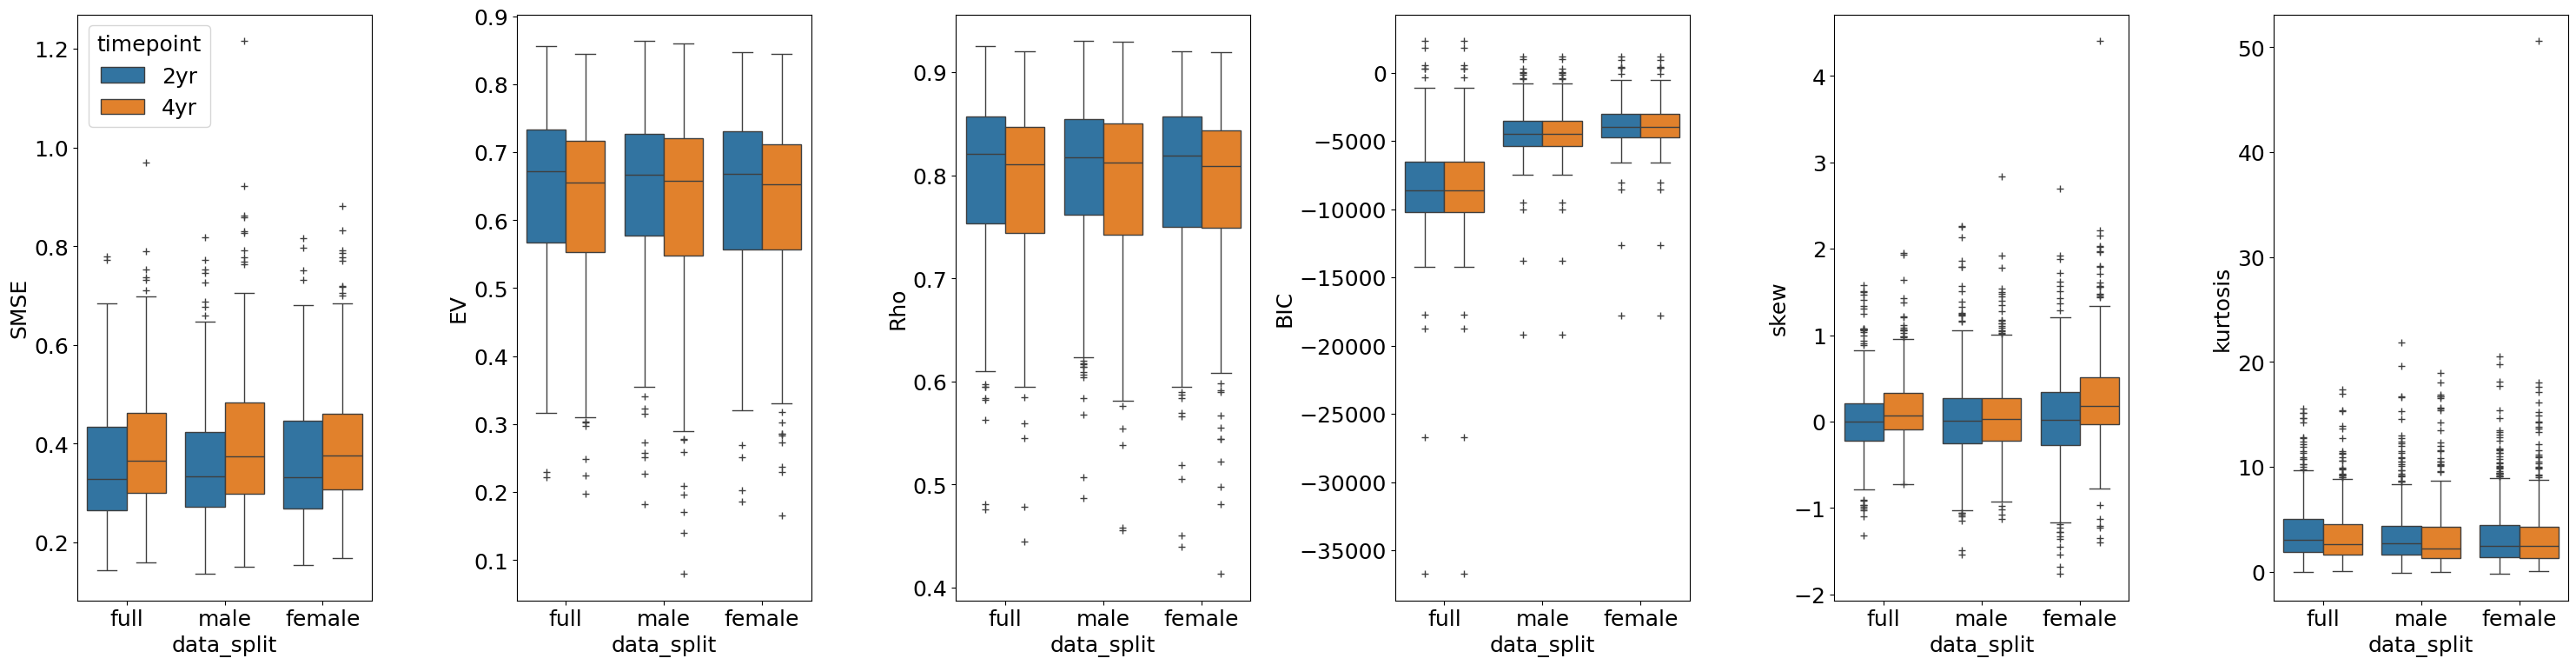

In [18]:
mpl.rcParams.update({'font.size': 18})

files = ["2yr_performance_w4yr.csv", "4yr_performance_w4yr.csv"]

plotter = Plotter(model)
fig, axes = plotter.plot_performances(data_splits, file_names=files, figsize=(30, 8), use_bspline=False)